# Project part 3 by Vladyslav Bezborodov

### Dataset - Animals-10

### [Github](https://github.com/vladyslavBrothervinn/DL4CV)


## Dataset Loading and Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split

import random
import time
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.model_selection import ParameterGrid

%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\Cyberpower\\PycharmProjects\\modelTraining\\DL4CV\\2025\\Practices'

In [3]:
data_dir = "../Datasets/raw-img"

In [5]:
def get_aspect_ratio(width, height):
    return width / height if height != 0 else 0

def get_raw_size(width, height):
    return width * height

def get_average_brightness(image):
    return np.mean(image)

In [6]:
def load_data(data_path):
    data = []

    for label in os.listdir(data_path):
        label_dir = os.path.join(data_path, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                file_extension = os.path.splitext(file_path)[1].lower()
                if file_path.endswith(('jpg', 'jpeg', 'png')):
                    with PIL.Image.open(file_path) as img:
                        width, height = img.size
                        img = np.array(img).reshape(-1)
                        average_brightness = get_average_brightness(img)
                        aspect_ratio = get_aspect_ratio(width, height)
                        raw_size = get_raw_size(width, height)

                        data.append([file, width, height, label, average_brightness, file_extension, aspect_ratio, raw_size])
                    
    return data

In [7]:
df = pd.DataFrame(
    load_data(data_dir), 
    columns=['Filename', 'Width', 'Height', 'Label', 'AverageBrightness', 'Extension', 'Aspect_Ratio', 'Raw_Size']
)

In [8]:
df.to_csv('../Datasets/animal-10_metadata.csv', index=False)

In [9]:
df.head()

,Filename,Width,Height,Label,AverageBrightness,Extension,Aspect_Ratio,Raw_Size
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,426,640,butterfly,147.072210,.jpg,0.665625,272640
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,640,457,butterfly,144.815149,.jpg,1.400438,292480
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,426,640,butterfly,173.383853,.jpg,0.665625,272640
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,425,640,butterfly,128.923267,.jpg,0.664062,272000
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,426,640,butterfly,160.853471,.jpg,0.665625,272640


In [10]:
df.describe()

,Width,Height,AverageBrightness,Aspect_Ratio,Raw_Size
count,26179.000000,26179.000000,26179.000000,26179.000000,2.617900e+04
mean,320.038810,252.630162,121.628519,1.311385,1.064363e+05
std,196.935326,148.403298,36.164577,0.311234,6.528056e+05
min,60.000000,57.000000,3.004002,0.293333,3.420000e+03
25%,300.000000,200.000000,99.050946,1.136364,6.000000e+04
50%,300.000000,225.000000,117.596617,1.333333,6.750000e+04
75%,300.000000,300.000000,138.670773,1.500000,7.410000e+04
max,6720.000000,6000.000000,250.052742,4.225352,3.010560e+07


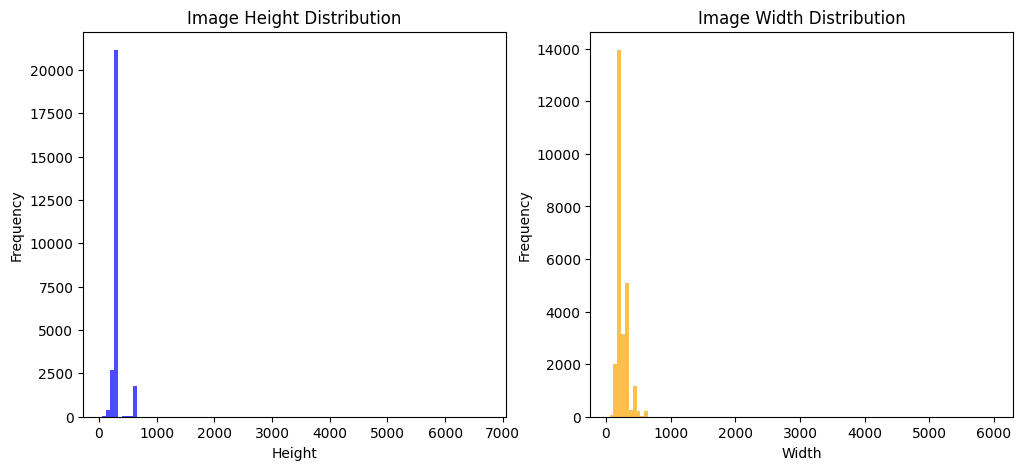

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df['Width'], bins=100, color='blue', alpha=0.7)
axes[0].set_title('Image Height Distribution')
axes[0].set_xlabel('Height')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Height'], bins=100, color='orange', alpha=0.7)
axes[1].set_title('Image Width Distribution')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Frequency')

plt.show()

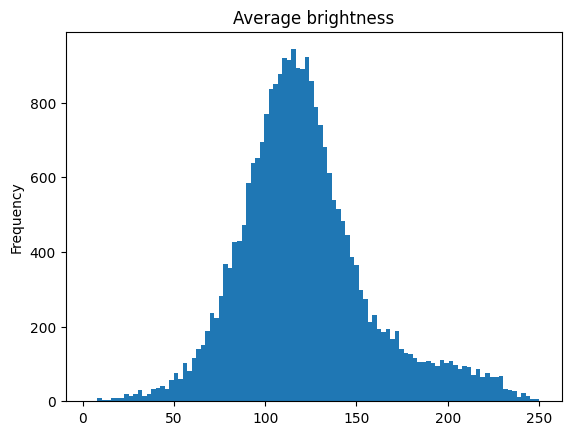

In [12]:
df['AverageBrightness'].plot(kind='hist', bins=100, title='Average brightness');

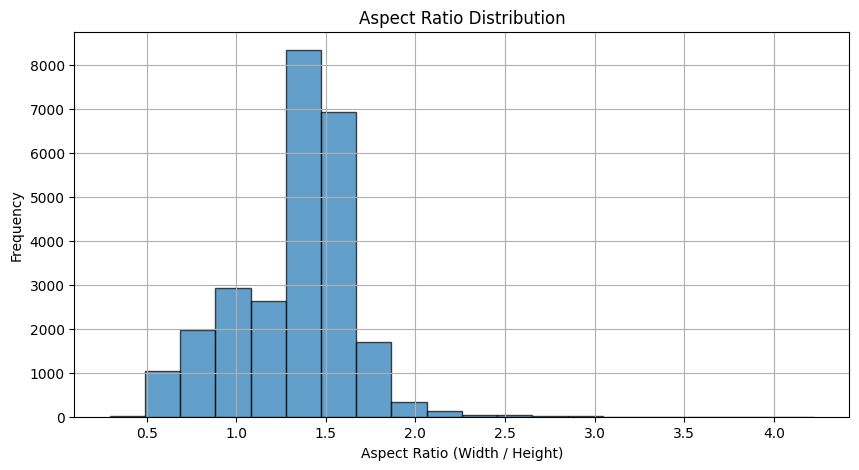

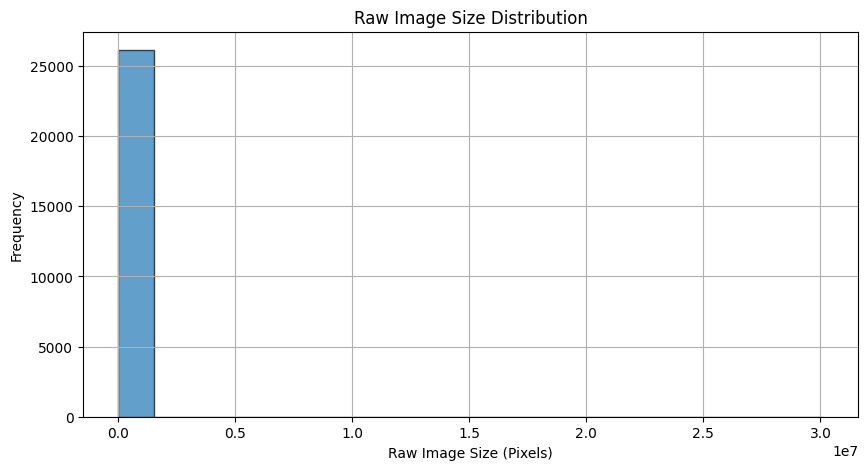

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df['Aspect_Ratio'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.title('Aspect Ratio Distribution')
plt.grid(True)
plt.show()

# Plot Raw Size Distribution
plt.figure(figsize=(10, 5))
plt.hist(df['Raw_Size'], bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Raw Image Size (Pixels)')
plt.ylabel('Frequency')
plt.title('Raw Image Size Distribution')
plt.grid(True)
plt.show()

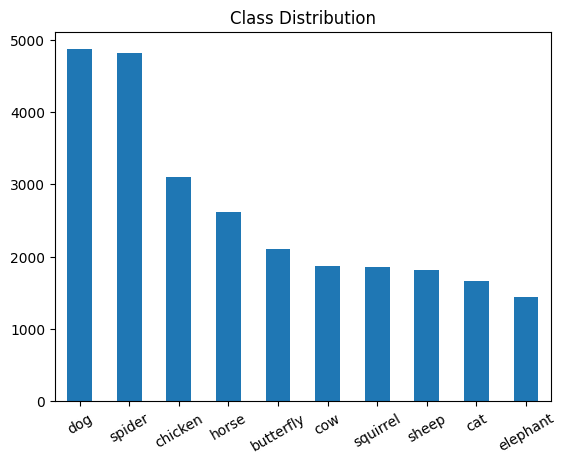

In [14]:
df['Label'].value_counts().plot(kind='bar', title='Class Distribution');
plt.xticks(rotation=30);

Dataset is not equally distributed by classes


two potential solutions:


- either reduce dog and spider classes images
- extend other classes that are < 2000 images

In [15]:
print("Amont of classes : ",len(df["Label"].unique()))

Amont of classes :  10


In [16]:
df['Label'].value_counts()

dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: Label, dtype: int64

## Dataset

In [4]:
# os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)


In [5]:
class AnimalDataset(Dataset):
    def __init__(self, data_dir, split="train", transform=None, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
        
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir)) 
        self.images = []
        self.labels = []

        all_data = []  # Store all images before splitting

        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) 
                               if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_data.extend([(img, label_idx) for img in image_files])  

        random.shuffle(all_data)
        
        # Compute split indices
        total = len(all_data)
        train_end = int(total * train_ratio)
        valid_end = train_end + int(total * valid_ratio)

        # Split dataset
        if split == "train":
            data_subset = all_data[:train_end]
        elif split == "valid":
            data_subset = all_data[train_end:valid_end]
        elif split == "test":
            data_subset = all_data[valid_end:]
        else:
            raise ValueError("split must be 'train', 'valid', or 'test'")

        # Store images and labels
        self.images, self.labels = zip(*data_subset) if data_subset else ([], [])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # Open image using PIL
        image = Image.open(image_path).convert("RGB")  # Convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [6]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

## Altered transformations

- resize to 128x128
- add more transforms

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

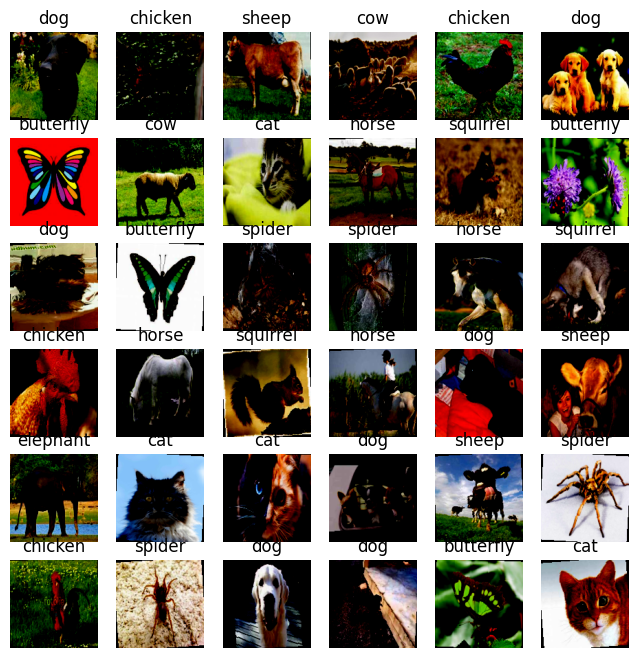

In [9]:
labels_map = {
    0: "butterfly",
    1: "cat",
    2: "chicken",
    3: "sheep",
    4: "dog",
    5: "elephant",
    6: "horse",
    7: "cow",
    8: "spider",
    9: "squirrel",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 6,6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    img = img.permute(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label.item()]) 
    plt.axis("off")
    plt.imshow(img) 

plt.show()


## Model Architecture (old)

In [10]:
# class Model(nn.Module):
    
#     def __init__(self, act_fn):
#         super().__init__()
#         self.act_fn = act_fn
        
#         self.conv1 = nn.Conv2d(3, 6, kernel_size= 5, padding=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size= 5) 
#         self.fc1 = nn.Linear(16*6*6,256)
#         self.fc2 = nn.Linear(256,128)
#         self.fc3 = nn.Linear(128,10)
#         self.dropout = nn.Dropout(p=0.5)

    
#     def forward(self, x):
#         # print(f"Shape before 1st avg pooling : {x.shape}")  # Debugging output
#         x = F.max_pool2d(self.act_fn(self.conv1(x)), kernel_size = 2, stride = 2)
#         # print(f"Shape after 1st avg pooling : {x.shape}")  # Debugging output
#         x = F.max_pool2d(self.act_fn(self.conv2(x)), kernel_size = 2, stride = 2)  
#         # print(f"Shape after 2nd avg pooling : {x.shape}")  # Debugging output

#         # print(f"Shape before flattening: {x.shape}")  # Debugging output
#         x = x.view(x.size(0), -1)  # Flatten the output
#         # print(f"Shape after flattening: {x.shape}")  # Debugging output
#         x = self.act_fn(self.fc1(x))
#         x = self.dropout(x)
#         x = self.act_fn(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)
        
#         return x 


## New Model

- new arrange of Conv layers, more channels
- lower dropout
- played with parameters

In [11]:
class Model_v2(nn.Module):
    
    def __init__(self, act_fn):
        super().__init__()
        self.act_fn = act_fn
        
        # Original input : 128x128x3
        self.conv1 = nn.Conv2d(3, 16, kernel_size= 3, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size= 3, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 3) 
        self.fc1 = nn.Linear(64*7*7,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,10)
        self.dropout = nn.Dropout(p=0.25)

    
    def forward(self, x):
        x = self.act_fn(self.conv1(x))
        # print(f"Shape before 1st pooling : {x.shape}")
        x = F.max_pool2d(self.act_fn(self.conv2(x)), kernel_size = 2, stride = 2)
        # print(f"Shape after 1st pooling : {x.shape}")
        x = F.max_pool2d(self.act_fn(self.conv3(x)), kernel_size = 2, stride = 2)
        # print(f"Shape after 2nd pooling : {x.shape}")  # Debugging output

        # print(f"Shape before flattening: {x.shape}")  # Debugging output
        x = x.view(x.size(0), -1)  # Flatten the output
        # print(f"Shape after flattening: {x.shape}")  # Debugging output
        x = self.act_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.act_fn(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


In [12]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [13]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

## Fit function

Integrated learning rate scheduler when val_loss is not improving for several epochs

In [14]:
def fit(epochs, model, idx, loss_func, optimizer, train_loader, valid_loader, patience=4, scheduler=None):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            if scheduler is not None:
                scheduler.step(valid_loss)
            
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), f'lab5/models/model_{idx}.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [15]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    return test_loss, test_accuracy

In [16]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [17]:
def train(model, idx, criterion, optimizer, n_epochs, batch_size, saving_model_path):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
    valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
    test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=batch_size, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=batch_size, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=batch_size, shuffle=False), to_device)
    
    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, idx, criterion, optimizer, train_loader, valid_loader, scheduler=scheduler)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load(f'lab5/models/model_{idx}.pt', map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save(model.state_dict(), model_path(saving_model_path))

    training_plots(losses_arr)
    return losses_arr, test_loss, test_accuracy

## Parameters grid

### New parameters config

- bigger batch size for a faster training
- removing SGD optimizer, as previous tranings showed its lower accuracy
- more learning rate's options
- keeping only 20 epochs, as there are already 24 models to get trained, too many capacity, have to leave smth aside

In [18]:
model_path = lambda name: f"lab5/models/animals/{name}.model"
params_grid = {
    "batch_size": [128,256],
    "lr": [0.004, 0.0025, 0.001],
    "epochs": [20],
    "activation_fn": [nn.GELU(), nn.LeakyReLU()],
    "optimizer" : [torch.optim.Adam, torch.optim.AdamW]
}

In [19]:
def grid_search(params_grid):
    param_grid = ParameterGrid(params_grid)
    df = pd.DataFrame(columns=["batch_size", "lr", "epochs", "activation_fn",
                               "optimizer", "losses_arr", "test_loss", "test_accuracy", "model"])

    idx = 0
    for params in param_grid:
        model = Model_v2(act_fn=params["activation_fn"]).to(device)
        
        if params["optimizer"] in [torch.optim.SGD]:
            optimizer = params["optimizer"](model.parameters(), lr=params["lr"], momentum=0.9)
        else:
            optimizer = params["optimizer"](model.parameters(), lr=params["lr"])
        
        criterion = nn.CrossEntropyLoss()
        losses_arr, test_loss, test_accuracy = train(model, idx, criterion, optimizer,
                                                     params["epochs"], params["batch_size"], 'base_model_'+str(idx))

        new_row = {
            "batch_size": params["batch_size"],
            "lr": params["lr"],
            "epochs": params["epochs"],
            "activation_fn": params["activation_fn"],
            "optimizer": params["optimizer"].__name__, 
            "losses_arr": losses_arr,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "model": "model_"+str(idx)
        }
        new_df = pd.DataFrame([new_row])
        df = pd.concat([df, new_df], ignore_index=True)
        
        idx += 1

        df.to_csv('lab5/models/models_results.csv', sep=',')
        print("results were saved to csv")
    return df



Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:29<28:13, 89.15s/it]


epoch:   1, loss: 1.81639, valid loss: 1.43746, valid accruacy: 49.819%
Validation loss decreased (inf --> 1.437461). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:01<27:19, 91.07s/it]


epoch:   2, loss: 1.37176, valid loss: 1.24662, valid accruacy: 56.848%
Validation loss decreased (1.437461 --> 1.246616). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:31<25:41, 90.65s/it]


epoch:   3, loss: 1.20072, valid loss: 1.12658, valid accruacy: 60.745%
Validation loss decreased (1.246616 --> 1.126577). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:01<24:07, 90.47s/it]


epoch:   4, loss: 1.07284, valid loss: 0.98284, valid accruacy: 66.743%
Validation loss decreased (1.126577 --> 0.982837). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:33<22:40, 90.73s/it]


epoch:   5, loss: 0.95998, valid loss: 0.95166, valid accruacy: 68.080%
Validation loss decreased (0.982837 --> 0.951661). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [09:03<21:09, 90.64s/it]


epoch:   6, loss: 0.86510, valid loss: 0.93280, valid accruacy: 68.883%
Validation loss decreased (0.951661 --> 0.932801). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [10:34<19:39, 90.77s/it]


epoch:   7, loss: 0.80275, valid loss: 0.72284, valid accruacy: 75.683%
Validation loss decreased (0.932801 --> 0.722841). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [12:04<18:07, 90.62s/it]


epoch:   8, loss: 0.70297, valid loss: 0.71184, valid accruacy: 77.268%
Validation loss decreased (0.722841 --> 0.711844). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [13:35<16:36, 90.63s/it]


epoch:   9, loss: 0.65211, valid loss: 0.67957, valid accruacy: 79.083%
Validation loss decreased (0.711844 --> 0.679574). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [15:05<15:05, 90.51s/it]


epoch:  10, loss: 0.60037, valid loss: 0.62595, valid accruacy: 80.115%
Validation loss decreased (0.679574 --> 0.625947). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [16:36<13:35, 90.57s/it]


epoch:  11, loss: 0.56667, valid loss: 0.58409, valid accruacy: 81.910%
Validation loss decreased (0.625947 --> 0.584090). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [18:07<12:06, 90.76s/it]


epoch:  12, loss: 0.54762, valid loss: 0.59790, valid accruacy: 81.624%


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [19:38<10:35, 90.79s/it]


epoch:  13, loss: 0.50281, valid loss: 0.61984, valid accruacy: 81.394%
Epoch 00013: reducing learning rate of group 0 to 2.0000e-03.


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [21:08<09:03, 90.59s/it]


epoch:  14, loss: 0.36097, valid loss: 0.45465, valid accruacy: 87.049%
Validation loss decreased (0.584090 --> 0.454649). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [22:39<07:33, 90.69s/it]


epoch:  15, loss: 0.26722, valid loss: 0.42517, valid accruacy: 88.195%
Validation loss decreased (0.454649 --> 0.425168). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [24:09<06:02, 90.52s/it]


epoch:  16, loss: 0.24097, valid loss: 0.42893, valid accruacy: 88.653%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [25:40<04:31, 90.56s/it]


epoch:  17, loss: 0.20749, valid loss: 0.41277, valid accruacy: 89.494%
Validation loss decreased (0.425168 --> 0.412772). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [27:11<03:01, 90.59s/it]


epoch:  18, loss: 0.18841, valid loss: 0.42535, valid accruacy: 89.265%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [28:41<01:30, 90.47s/it]


epoch:  19, loss: 0.18269, valid loss: 0.42105, valid accruacy: 90.143%
Epoch 00019: reducing learning rate of group 0 to 1.0000e-03.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [30:12<00:00, 90.60s/it]


epoch:  20, loss: 0.12468, valid loss: 0.41791, valid accruacy: 90.946%
Fit time: 1812.0195331573486 s


Test loss: 0.41758	Test accruacy: 89.462%
Saving model


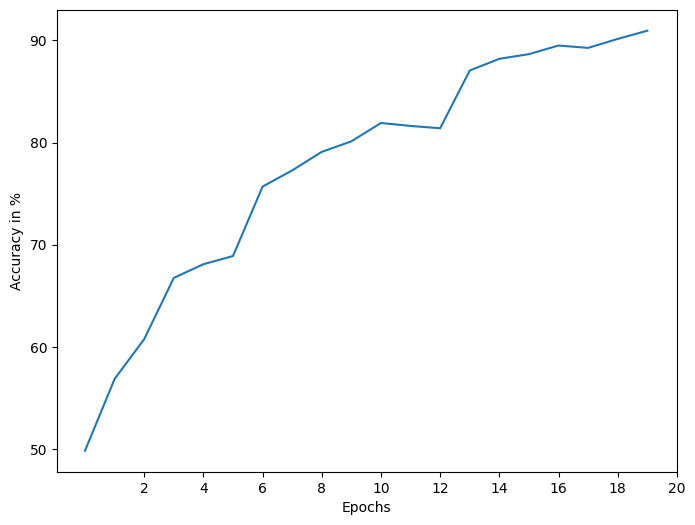

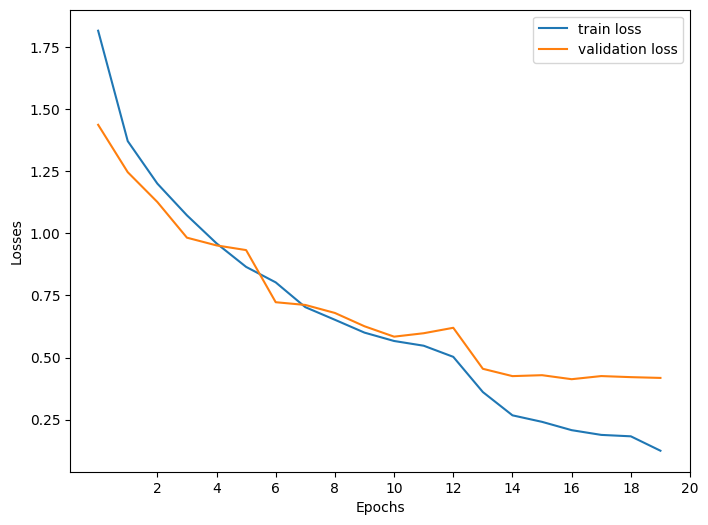

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:30<28:33, 90.20s/it]


epoch:   1, loss: 1.93571, valid loss: 1.63948, valid accruacy: 43.114%
Validation loss decreased (inf --> 1.639483). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:59<26:58, 89.94s/it]


epoch:   2, loss: 1.48133, valid loss: 1.35143, valid accruacy: 52.092%
Validation loss decreased (1.639483 --> 1.351427). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:30<25:31, 90.07s/it]


epoch:   3, loss: 1.26771, valid loss: 1.08175, valid accruacy: 62.789%
Validation loss decreased (1.351427 --> 1.081751). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:00<24:04, 90.27s/it]


epoch:   4, loss: 1.12053, valid loss: 1.03912, valid accruacy: 64.527%
Validation loss decreased (1.081751 --> 1.039125). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:31<22:35, 90.38s/it]


epoch:   5, loss: 1.00631, valid loss: 0.94824, valid accruacy: 68.271%
Validation loss decreased (1.039125 --> 0.948239). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [09:02<21:07, 90.50s/it]


epoch:   6, loss: 0.91487, valid loss: 0.84316, valid accruacy: 71.767%
Validation loss decreased (0.948239 --> 0.843163). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [10:31<19:33, 90.26s/it]


epoch:   7, loss: 0.83235, valid loss: 0.78490, valid accruacy: 74.002%
Validation loss decreased (0.843163 --> 0.784897). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [12:04<18:14, 91.17s/it]


epoch:   8, loss: 0.75917, valid loss: 0.66622, valid accruacy: 78.758%
Validation loss decreased (0.784897 --> 0.666216). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [13:36<16:43, 91.20s/it]


epoch:   9, loss: 0.70548, valid loss: 0.63998, valid accruacy: 78.911%
Validation loss decreased (0.666216 --> 0.639980). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [15:06<15:08, 90.87s/it]


epoch:  10, loss: 0.65259, valid loss: 0.64382, valid accruacy: 79.293%


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [16:36<13:36, 90.69s/it]


epoch:  11, loss: 0.59635, valid loss: 0.58761, valid accruacy: 81.337%
Validation loss decreased (0.639980 --> 0.587606). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [18:08<12:09, 91.18s/it]


epoch:  12, loss: 0.57932, valid loss: 0.56964, valid accruacy: 82.693%
Validation loss decreased (0.587606 --> 0.569640). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [19:40<10:39, 91.33s/it]


epoch:  13, loss: 0.55299, valid loss: 0.54472, valid accruacy: 83.228%
Validation loss decreased (0.569640 --> 0.544719). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [21:11<09:06, 91.14s/it]


epoch:  14, loss: 0.49773, valid loss: 0.47255, valid accruacy: 85.444%
Validation loss decreased (0.544719 --> 0.472553). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [22:41<07:33, 90.78s/it]


epoch:  15, loss: 0.48559, valid loss: 0.49808, valid accruacy: 85.196%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [24:11<06:02, 90.72s/it]


epoch:  16, loss: 0.46796, valid loss: 0.50178, valid accruacy: 85.119%
Epoch 00016: reducing learning rate of group 0 to 2.0000e-03.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [25:42<04:31, 90.60s/it]


epoch:  17, loss: 0.30679, valid loss: 0.38538, valid accruacy: 88.768%
Validation loss decreased (0.472553 --> 0.385378). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [27:12<03:01, 90.58s/it]


epoch:  18, loss: 0.22747, valid loss: 0.40688, valid accruacy: 89.494%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [28:42<01:30, 90.35s/it]


epoch:  19, loss: 0.20446, valid loss: 0.36053, valid accruacy: 90.602%
Validation loss decreased (0.385378 --> 0.360526). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [30:12<00:00, 90.63s/it]


epoch:  20, loss: 0.18420, valid loss: 0.38927, valid accruacy: 90.506%
Fit time: 1812.511666059494 s


Test loss: 0.36320	Test accruacy: 90.836%
Saving model


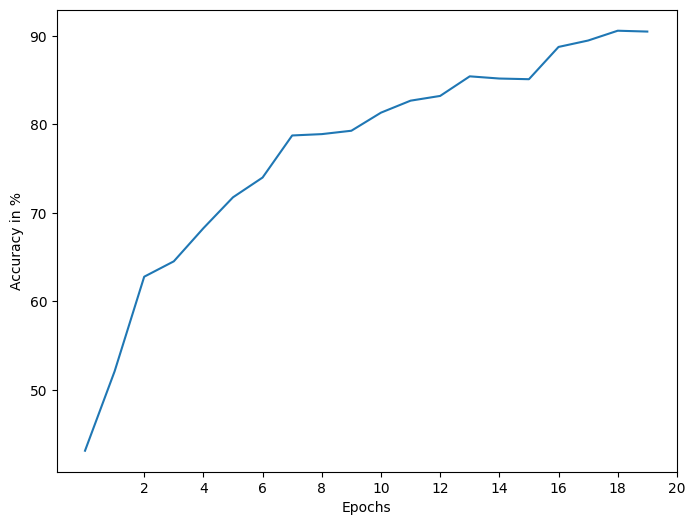

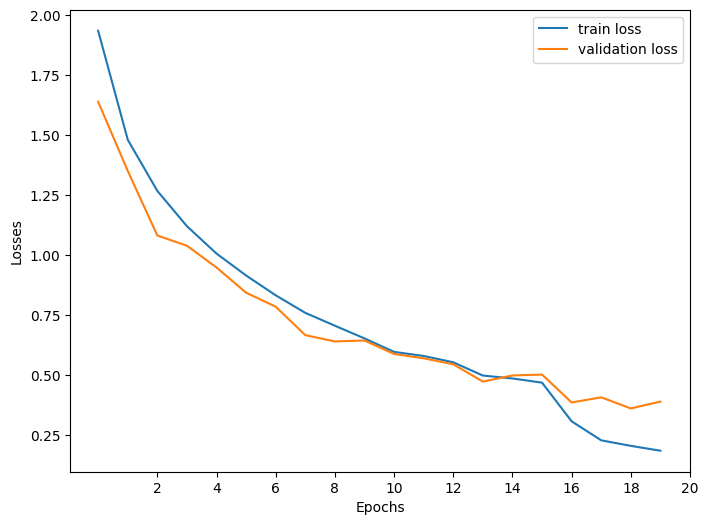

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:32<29:10, 92.15s/it]


epoch:   1, loss: 1.81592, valid loss: 1.43823, valid accruacy: 49.723%
Validation loss decreased (inf --> 1.438229). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:03<27:28, 91.57s/it]


epoch:   2, loss: 1.32931, valid loss: 1.20236, valid accruacy: 58.491%
Validation loss decreased (1.438229 --> 1.202364). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:34<25:51, 91.26s/it]


epoch:   3, loss: 1.13124, valid loss: 1.02560, valid accruacy: 64.795%
Validation loss decreased (1.202364 --> 1.025597). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:05<24:17, 91.12s/it]


epoch:   4, loss: 0.99555, valid loss: 0.91103, valid accruacy: 68.749%
Validation loss decreased (1.025597 --> 0.911033). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:36<22:46, 91.13s/it]


epoch:   5, loss: 0.87761, valid loss: 0.88965, valid accruacy: 70.392%
Validation loss decreased (0.911033 --> 0.889651). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [09:06<21:13, 90.97s/it]


epoch:   6, loss: 0.76517, valid loss: 0.72039, valid accruacy: 76.332%
Validation loss decreased (0.889651 --> 0.720394). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [10:37<19:42, 90.95s/it]


epoch:   7, loss: 0.67090, valid loss: 0.66657, valid accruacy: 78.777%
Validation loss decreased (0.720394 --> 0.666569). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [12:09<18:14, 91.17s/it]


epoch:   8, loss: 0.57639, valid loss: 0.58876, valid accruacy: 81.872%
Validation loss decreased (0.666569 --> 0.588758). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [13:40<16:43, 91.20s/it]


epoch:   9, loss: 0.50672, valid loss: 0.55686, valid accruacy: 82.980%
Validation loss decreased (0.588758 --> 0.556855). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [15:11<15:09, 91.00s/it]


epoch:  10, loss: 0.43837, valid loss: 0.53618, valid accruacy: 84.680%
Validation loss decreased (0.556855 --> 0.536177). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [16:42<13:40, 91.16s/it]


epoch:  11, loss: 0.39612, valid loss: 0.51998, valid accruacy: 85.043%
Validation loss decreased (0.536177 --> 0.519977). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [18:13<12:08, 91.02s/it]


epoch:  12, loss: 0.35504, valid loss: 0.48353, valid accruacy: 87.221%
Validation loss decreased (0.519977 --> 0.483527). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [19:45<10:38, 91.17s/it]


epoch:  13, loss: 0.31212, valid loss: 0.46180, valid accruacy: 87.813%
Validation loss decreased (0.483527 --> 0.461801). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [21:15<09:05, 90.96s/it]


epoch:  14, loss: 0.29107, valid loss: 0.49236, valid accruacy: 87.488%


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [22:46<07:35, 91.03s/it]


epoch:  15, loss: 0.26901, valid loss: 0.47067, valid accruacy: 88.080%
Epoch 00015: reducing learning rate of group 0 to 1.2500e-03.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [24:18<06:04, 91.16s/it]


epoch:  16, loss: 0.17256, valid loss: 0.38872, valid accruacy: 90.716%
Validation loss decreased (0.461801 --> 0.388717). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [25:49<04:33, 91.16s/it]


epoch:  17, loss: 0.12790, valid loss: 0.41123, valid accruacy: 90.869%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [27:20<03:02, 91.13s/it]


epoch:  18, loss: 0.10320, valid loss: 0.41014, valid accruacy: 91.079%
Epoch 00018: reducing learning rate of group 0 to 6.2500e-04.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [28:51<01:31, 91.23s/it]


epoch:  19, loss: 0.07736, valid loss: 0.40508, valid accruacy: 91.347%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [30:22<01:35, 95.92s/it]


epoch:  20, loss: 0.06393, valid loss: 0.39793, valid accruacy: 91.786%
Epoch 00020: reducing learning rate of group 0 to 3.1250e-04.
Terminated Training for Early Stopping at Epoch 20
Fit time: 1822.4152419567108 s


Test loss: 0.38284	Test accruacy: 91.065%
Saving model


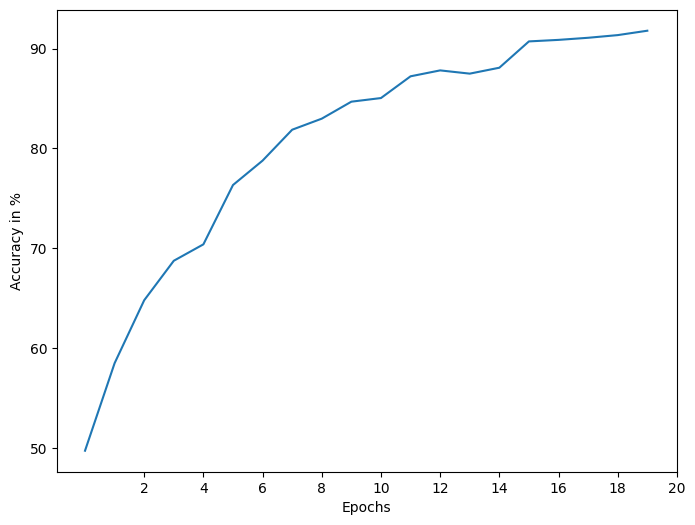

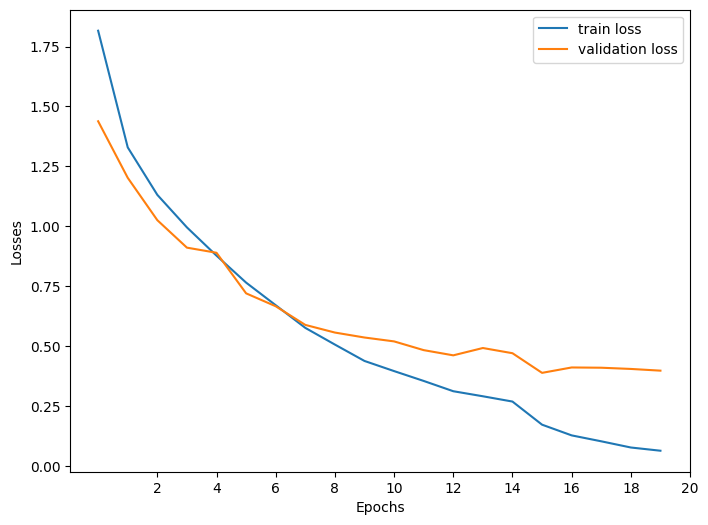

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:31<29:05, 91.85s/it]


epoch:   1, loss: 1.79343, valid loss: 1.48339, valid accruacy: 48.023%
Validation loss decreased (inf --> 1.483390). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:04<27:37, 92.06s/it]


epoch:   2, loss: 1.35809, valid loss: 1.15526, valid accruacy: 60.917%
Validation loss decreased (1.483390 --> 1.155262). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:35<25:58, 91.70s/it]


epoch:   3, loss: 1.17331, valid loss: 1.08375, valid accruacy: 62.751%
Validation loss decreased (1.155262 --> 1.083747). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:08<24:33, 92.11s/it]


epoch:   4, loss: 1.04151, valid loss: 0.91616, valid accruacy: 68.672%
Validation loss decreased (1.083747 --> 0.916158). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:40<23:02, 92.18s/it]


epoch:   5, loss: 0.90348, valid loss: 0.78317, valid accruacy: 73.734%
Validation loss decreased (0.916158 --> 0.783168). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [09:11<21:27, 91.96s/it]


epoch:   6, loss: 0.79150, valid loss: 0.72297, valid accruacy: 75.549%
Validation loss decreased (0.783168 --> 0.722970). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [10:45<20:02, 92.46s/it]


epoch:   7, loss: 0.68429, valid loss: 0.68625, valid accruacy: 77.956%
Validation loss decreased (0.722970 --> 0.686255). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [12:19<18:34, 92.87s/it]


epoch:   8, loss: 0.61341, valid loss: 0.60727, valid accruacy: 80.821%
Validation loss decreased (0.686255 --> 0.607274). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [13:51<16:58, 92.56s/it]


epoch:   9, loss: 0.53116, valid loss: 0.56600, valid accruacy: 82.598%
Validation loss decreased (0.607274 --> 0.565997). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [15:23<15:24, 92.49s/it]


epoch:  10, loss: 0.46141, valid loss: 0.51534, valid accruacy: 84.585%
Validation loss decreased (0.565997 --> 0.515340). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [16:55<13:52, 92.51s/it]


epoch:  11, loss: 0.42644, valid loss: 0.52580, valid accruacy: 84.317%


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [18:28<12:19, 92.39s/it]


epoch:  12, loss: 0.38293, valid loss: 0.47851, valid accruacy: 86.399%
Validation loss decreased (0.515340 --> 0.478510). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [19:59<10:45, 92.20s/it]


epoch:  13, loss: 0.34541, valid loss: 0.58164, valid accruacy: 83.801%


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [21:31<09:12, 92.06s/it]


epoch:  14, loss: 0.30873, valid loss: 0.45937, valid accruacy: 88.061%
Validation loss decreased (0.478510 --> 0.459375). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [23:05<07:43, 92.66s/it]


epoch:  15, loss: 0.27371, valid loss: 0.47506, valid accruacy: 88.138%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [24:37<06:09, 92.35s/it]


epoch:  16, loss: 0.27060, valid loss: 0.46732, valid accruacy: 88.252%
Epoch 00016: reducing learning rate of group 0 to 1.2500e-03.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [26:09<04:36, 92.20s/it]


epoch:  17, loss: 0.16755, valid loss: 0.39203, valid accruacy: 90.544%
Validation loss decreased (0.459375 --> 0.392032). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [27:40<03:04, 92.08s/it]


epoch:  18, loss: 0.12529, valid loss: 0.40834, valid accruacy: 90.888%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [29:12<01:31, 91.96s/it]


epoch:  19, loss: 0.10916, valid loss: 0.41780, valid accruacy: 90.946%
Epoch 00019: reducing learning rate of group 0 to 6.2500e-04.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [30:44<00:00, 92.21s/it]


epoch:  20, loss: 0.08191, valid loss: 0.39372, valid accruacy: 91.404%
Fit time: 1844.2338166236877 s


Test loss: 0.36690	Test accruacy: 91.714%
Saving model


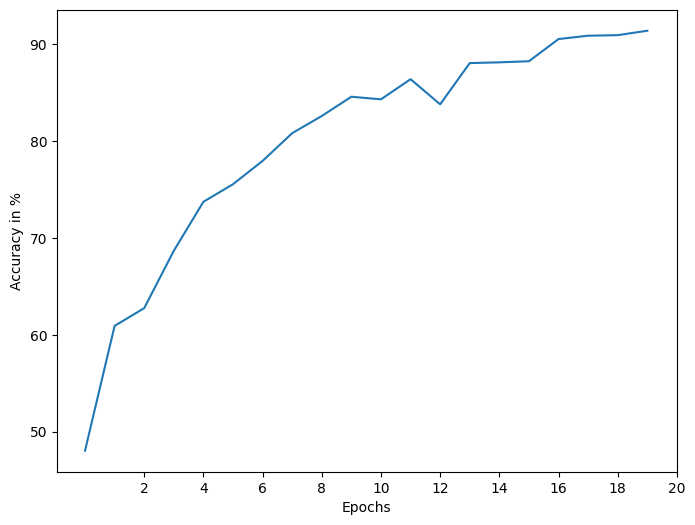

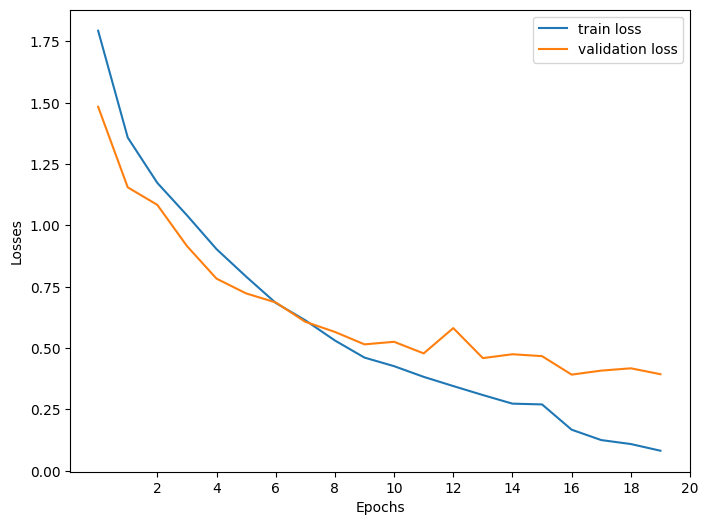

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:31<28:49, 91.01s/it]


epoch:   1, loss: 1.92730, valid loss: 1.62199, valid accruacy: 43.075%
Validation loss decreased (inf --> 1.621988). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:03<27:37, 92.06s/it]


epoch:   2, loss: 1.52171, valid loss: 1.34770, valid accruacy: 53.486%
Validation loss decreased (1.621988 --> 1.347698). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:25<24:47, 87.51s/it]


epoch:   3, loss: 1.30233, valid loss: 1.13422, valid accruacy: 61.662%
Validation loss decreased (1.347698 --> 1.134216). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:57<23:48, 89.25s/it]


epoch:   4, loss: 1.13788, valid loss: 1.03640, valid accruacy: 65.559%
Validation loss decreased (1.134216 --> 1.036404). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:33<22:56, 91.74s/it]


epoch:   5, loss: 1.00716, valid loss: 0.90927, valid accruacy: 69.685%
Validation loss decreased (1.036404 --> 0.909274). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:53<20:26, 87.62s/it]


epoch:   6, loss: 0.87522, valid loss: 0.78149, valid accruacy: 74.441%
Validation loss decreased (0.909274 --> 0.781488). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [10:20<18:55, 87.37s/it]


epoch:   7, loss: 0.76752, valid loss: 0.69154, valid accruacy: 77.154%
Validation loss decreased (0.781488 --> 0.691545). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [11:43<17:12, 86.07s/it]


epoch:   8, loss: 0.65843, valid loss: 0.64639, valid accruacy: 78.720%
Validation loss decreased (0.691545 --> 0.646393). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:59<15:12, 82.93s/it]


epoch:   9, loss: 0.56251, valid loss: 0.57095, valid accruacy: 82.197%
Validation loss decreased (0.646393 --> 0.570954). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [14:10<13:12, 79.20s/it]


epoch:  10, loss: 0.45323, valid loss: 0.51978, valid accruacy: 84.011%
Validation loss decreased (0.570954 --> 0.519782). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [15:20<11:27, 76.43s/it]


epoch:  11, loss: 0.37410, valid loss: 0.47781, valid accruacy: 85.845%
Validation loss decreased (0.519782 --> 0.477806). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [16:32<09:59, 74.93s/it]


epoch:  12, loss: 0.34025, valid loss: 0.44628, valid accruacy: 87.068%
Validation loss decreased (0.477806 --> 0.446284). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [17:44<08:38, 74.01s/it]


epoch:  13, loss: 0.28282, valid loss: 0.41690, valid accruacy: 88.577%
Validation loss decreased (0.446284 --> 0.416902). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [18:54<07:17, 72.94s/it]


epoch:  14, loss: 0.23357, valid loss: 0.41194, valid accruacy: 89.150%
Validation loss decreased (0.416902 --> 0.411936). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [20:05<06:01, 72.22s/it]


epoch:  15, loss: 0.23232, valid loss: 0.40118, valid accruacy: 89.054%
Validation loss decreased (0.411936 --> 0.401181). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [21:15<04:46, 71.72s/it]


epoch:  16, loss: 0.18235, valid loss: 0.39420, valid accruacy: 89.532%
Validation loss decreased (0.401181 --> 0.394205). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [22:24<03:32, 70.92s/it]


epoch:  17, loss: 0.16186, valid loss: 0.41944, valid accruacy: 90.067%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [23:37<02:22, 71.50s/it]


epoch:  18, loss: 0.14858, valid loss: 0.42647, valid accruacy: 89.570%
Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [24:48<01:11, 71.22s/it]


epoch:  19, loss: 0.09863, valid loss: 0.39337, valid accruacy: 90.793%
Validation loss decreased (0.394205 --> 0.393366). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [25:59<00:00, 77.96s/it]


epoch:  20, loss: 0.07685, valid loss: 0.40253, valid accruacy: 91.175%
Fit time: 1559.2611961364746 s


Test loss: 0.41822	Test accruacy: 90.760%
Saving model


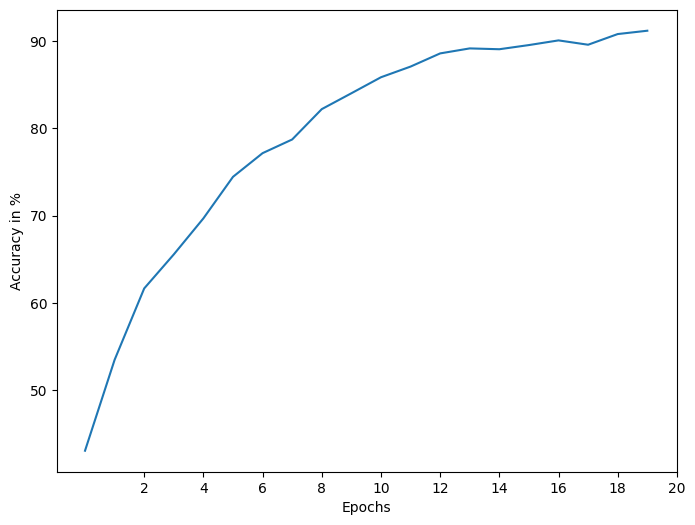

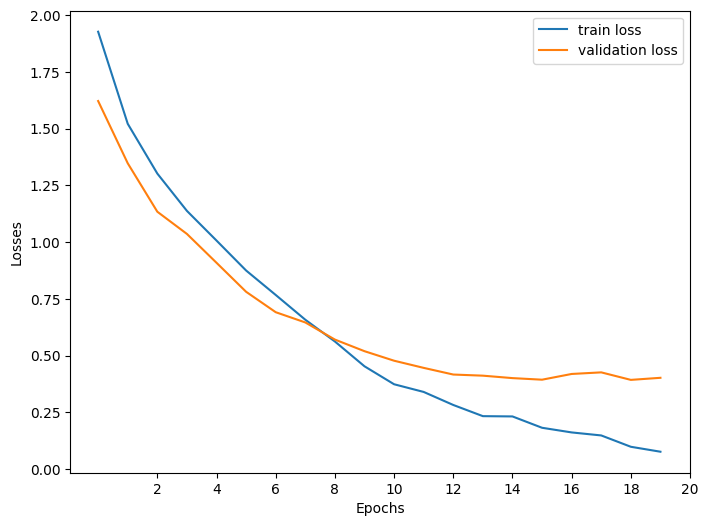

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:10<22:20, 70.53s/it]


epoch:   1, loss: 1.90255, valid loss: 1.60139, valid accruacy: 44.222%
Validation loss decreased (inf --> 1.601389). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:20<21:06, 70.35s/it]


epoch:   2, loss: 1.49674, valid loss: 1.39579, valid accruacy: 51.824%
Validation loss decreased (1.601389 --> 1.395792). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:31<19:58, 70.47s/it]


epoch:   3, loss: 1.26543, valid loss: 1.11920, valid accruacy: 62.197%
Validation loss decreased (1.395792 --> 1.119200). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:42<18:49, 70.58s/it]


epoch:   4, loss: 1.10730, valid loss: 1.00073, valid accruacy: 65.903%
Validation loss decreased (1.119200 --> 1.000735). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:54<17:46, 71.10s/it]


epoch:   5, loss: 0.98067, valid loss: 0.92399, valid accruacy: 68.233%
Validation loss decreased (1.000735 --> 0.923986). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:04<16:32, 70.87s/it]


epoch:   6, loss: 0.87756, valid loss: 0.78978, valid accruacy: 73.945%
Validation loss decreased (0.923986 --> 0.789783). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:16<15:25, 71.17s/it]


epoch:   7, loss: 0.74975, valid loss: 0.71091, valid accruacy: 76.753%
Validation loss decreased (0.789783 --> 0.710908). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:27<14:14, 71.21s/it]


epoch:   8, loss: 0.65664, valid loss: 0.66420, valid accruacy: 78.529%
Validation loss decreased (0.710908 --> 0.664195). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:39<13:06, 71.51s/it]


epoch:   9, loss: 0.56417, valid loss: 0.59298, valid accruacy: 81.414%
Validation loss decreased (0.664195 --> 0.592978). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:50<11:52, 71.30s/it]


epoch:  10, loss: 0.47861, valid loss: 0.51405, valid accruacy: 84.050%
Validation loss decreased (0.592978 --> 0.514055). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [13:01<10:40, 71.17s/it]


epoch:  11, loss: 0.40033, valid loss: 0.46791, valid accruacy: 85.960%
Validation loss decreased (0.514055 --> 0.467907). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:15<09:35, 71.99s/it]


epoch:  12, loss: 0.34348, valid loss: 0.45415, valid accruacy: 86.972%
Validation loss decreased (0.467907 --> 0.454149). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [15:29<08:27, 72.53s/it]


epoch:  13, loss: 0.28050, valid loss: 0.46563, valid accruacy: 86.896%


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [16:40<07:12, 72.02s/it]


epoch:  14, loss: 0.24608, valid loss: 0.42472, valid accruacy: 88.768%
Validation loss decreased (0.454149 --> 0.424722). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [17:51<05:59, 71.85s/it]


epoch:  15, loss: 0.21846, valid loss: 0.40969, valid accruacy: 89.456%
Validation loss decreased (0.424722 --> 0.409685). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [19:02<04:45, 71.46s/it]


epoch:  16, loss: 0.17534, valid loss: 0.42966, valid accruacy: 89.704%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [20:13<03:34, 71.50s/it]


epoch:  17, loss: 0.16415, valid loss: 0.39570, valid accruacy: 89.971%
Validation loss decreased (0.409685 --> 0.395701). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [21:24<02:22, 71.34s/it]


epoch:  18, loss: 0.14664, valid loss: 0.38682, valid accruacy: 90.716%
Validation loss decreased (0.395701 --> 0.386823). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [22:35<01:11, 71.25s/it]


epoch:  19, loss: 0.12743, valid loss: 0.42221, valid accruacy: 90.621%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:46<00:00, 71.33s/it]


epoch:  20, loss: 0.11765, valid loss: 0.42501, valid accruacy: 90.315%
Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.
Fit time: 1426.530174255371 s


Test loss: 0.39224	Test accruacy: 90.722%
Saving model


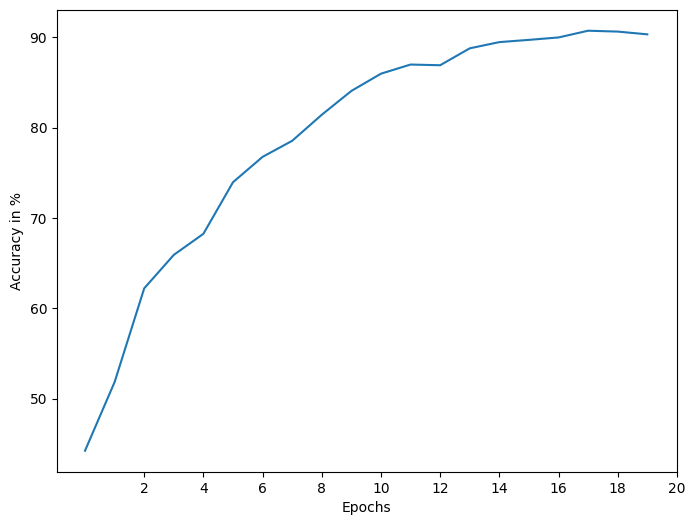

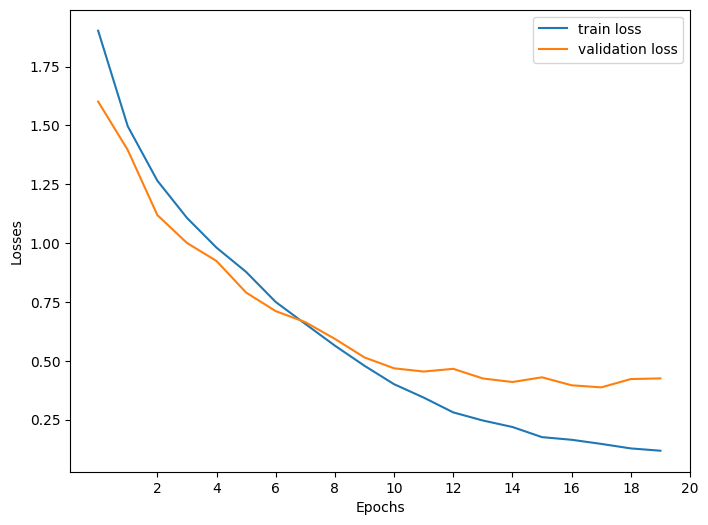

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:11<22:31, 71.13s/it]


epoch:   1, loss: 2.04674, valid loss: 1.75593, valid accruacy: 37.670%
Validation loss decreased (inf --> 1.755928). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:22<21:26, 71.49s/it]


epoch:   2, loss: 1.61237, valid loss: 1.38035, valid accruacy: 51.423%
Validation loss decreased (1.755928 --> 1.380347). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:33<20:11, 71.26s/it]


epoch:   3, loss: 1.33209, valid loss: 1.19939, valid accruacy: 59.198%
Validation loss decreased (1.380347 --> 1.199392). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:44<18:54, 70.92s/it]


epoch:   4, loss: 1.15741, valid loss: 1.01518, valid accruacy: 65.177%
Validation loss decreased (1.199392 --> 1.015178). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:55<17:43, 70.91s/it]


epoch:   5, loss: 1.03342, valid loss: 0.94222, valid accruacy: 67.316%
Validation loss decreased (1.015178 --> 0.942220). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:05<16:31, 70.82s/it]


epoch:   6, loss: 0.93065, valid loss: 0.86000, valid accruacy: 70.850%
Validation loss decreased (0.942220 --> 0.859996). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:16<15:19, 70.77s/it]


epoch:   7, loss: 0.81210, valid loss: 0.77321, valid accruacy: 73.868%
Validation loss decreased (0.859996 --> 0.773205). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:27<14:09, 70.79s/it]


epoch:   8, loss: 0.73397, valid loss: 0.68796, valid accruacy: 77.803%
Validation loss decreased (0.773205 --> 0.687963). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:38<12:58, 70.80s/it]


epoch:   9, loss: 0.66165, valid loss: 0.61942, valid accruacy: 80.210%
Validation loss decreased (0.687963 --> 0.619424). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:48<11:48, 70.80s/it]


epoch:  10, loss: 0.56971, valid loss: 0.55962, valid accruacy: 82.044%
Validation loss decreased (0.619424 --> 0.559624). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [13:00<10:38, 70.96s/it]


epoch:  11, loss: 0.50205, valid loss: 0.55006, valid accruacy: 82.445%
Validation loss decreased (0.559624 --> 0.550056). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:28<10:09, 76.24s/it]


epoch:  12, loss: 0.45512, valid loss: 0.49275, valid accruacy: 84.947%
Validation loss decreased (0.550056 --> 0.492747). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [15:51<09:08, 78.35s/it]


epoch:  13, loss: 0.39741, valid loss: 0.51978, valid accruacy: 84.795%


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [17:15<08:00, 80.06s/it]


epoch:  14, loss: 0.38817, valid loss: 0.42539, valid accruacy: 86.972%
Validation loss decreased (0.492747 --> 0.425386). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [18:38<06:43, 80.72s/it]


epoch:  15, loss: 0.33763, valid loss: 0.45824, valid accruacy: 87.221%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [20:01<05:25, 81.47s/it]


epoch:  16, loss: 0.30761, valid loss: 0.47561, valid accruacy: 87.106%
Epoch 00016: reducing learning rate of group 0 to 2.0000e-03.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [21:25<04:06, 82.19s/it]


epoch:  17, loss: 0.20293, valid loss: 0.40487, valid accruacy: 90.067%
Validation loss decreased (0.425386 --> 0.404870). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [22:47<02:44, 82.16s/it]


epoch:  18, loss: 0.15740, valid loss: 0.37524, valid accruacy: 90.564%
Validation loss decreased (0.404870 --> 0.375237). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [24:09<01:22, 82.18s/it]


epoch:  19, loss: 0.13803, valid loss: 0.40457, valid accruacy: 90.793%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [25:31<00:00, 76.56s/it]


epoch:  20, loss: 0.11128, valid loss: 0.37528, valid accruacy: 91.347%
Epoch 00020: reducing learning rate of group 0 to 1.0000e-03.
Fit time: 1531.2250037193298 s


Test loss: 0.35730	Test accruacy: 91.103%
Saving model


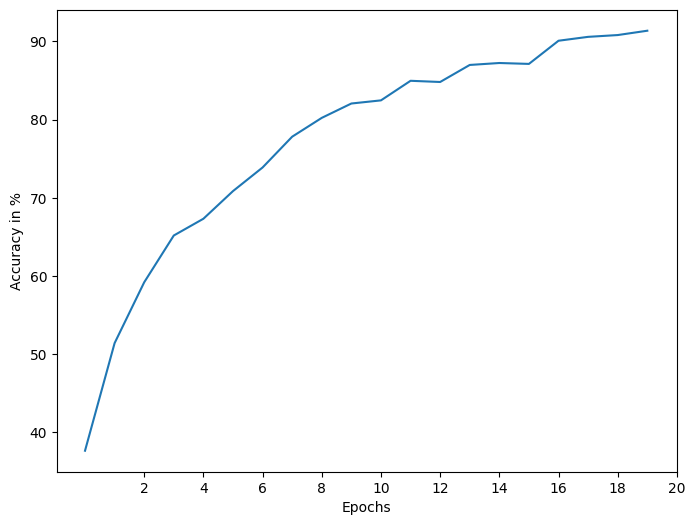

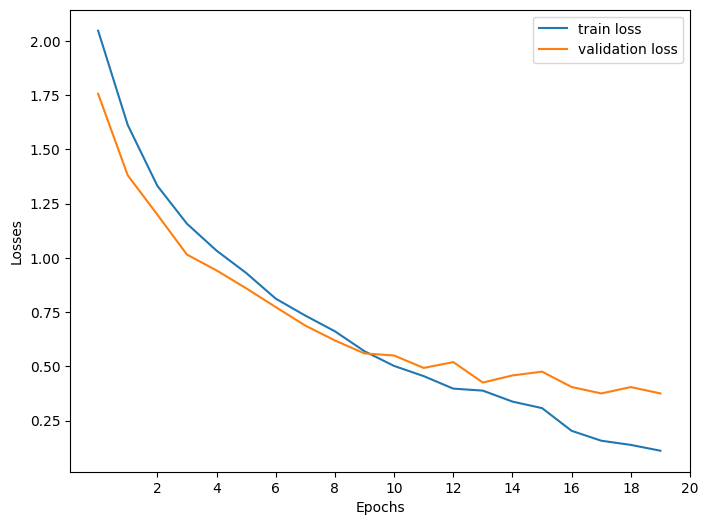

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:21<25:52, 81.72s/it]


epoch:   1, loss: 1.96396, valid loss: 1.57469, valid accruacy: 44.413%
Validation loss decreased (inf --> 1.574689). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:43<24:33, 81.85s/it]


epoch:   2, loss: 1.47653, valid loss: 1.29923, valid accruacy: 54.919%
Validation loss decreased (1.574689 --> 1.299231). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:04<23:05, 81.50s/it]


epoch:   3, loss: 1.24938, valid loss: 1.11374, valid accruacy: 62.082%
Validation loss decreased (1.299231 --> 1.113745). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:27<21:50, 81.93s/it]


epoch:   4, loss: 1.11000, valid loss: 0.97486, valid accruacy: 66.724%
Validation loss decreased (1.113745 --> 0.974857). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [06:49<20:31, 82.09s/it]


epoch:   5, loss: 0.96741, valid loss: 0.86738, valid accruacy: 71.251%
Validation loss decreased (0.974857 --> 0.867381). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:11<19:09, 82.11s/it]


epoch:   6, loss: 0.86858, valid loss: 0.80441, valid accruacy: 73.142%
Validation loss decreased (0.867381 --> 0.804413). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:33<17:44, 81.91s/it]


epoch:   7, loss: 0.74750, valid loss: 0.69859, valid accruacy: 77.402%
Validation loss decreased (0.804413 --> 0.698592). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [10:55<16:23, 81.95s/it]


epoch:   8, loss: 0.66448, valid loss: 0.69486, valid accruacy: 77.211%
Validation loss decreased (0.698592 --> 0.694863). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:16<14:59, 81.79s/it]


epoch:   9, loss: 0.59665, valid loss: 0.61910, valid accruacy: 80.688%
Validation loss decreased (0.694863 --> 0.619105). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [13:38<13:37, 81.71s/it]


epoch:  10, loss: 0.52456, valid loss: 0.55101, valid accruacy: 83.075%
Validation loss decreased (0.619105 --> 0.551014). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [15:00<12:16, 81.84s/it]


epoch:  11, loss: 0.47675, valid loss: 0.55385, valid accruacy: 83.859%


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [16:22<10:55, 81.98s/it]


epoch:  12, loss: 0.40685, valid loss: 0.53268, valid accruacy: 84.432%
Validation loss decreased (0.551014 --> 0.532684). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [17:44<09:33, 81.93s/it]


epoch:  13, loss: 0.37820, valid loss: 0.49941, valid accruacy: 85.922%
Validation loss decreased (0.532684 --> 0.499409). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [19:07<08:13, 82.20s/it]


epoch:  14, loss: 0.34762, valid loss: 0.47404, valid accruacy: 86.800%
Validation loss decreased (0.499409 --> 0.474044). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [20:29<06:51, 82.26s/it]


epoch:  15, loss: 0.31610, valid loss: 0.44881, valid accruacy: 87.870%
Validation loss decreased (0.474044 --> 0.448809). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [21:52<05:29, 82.25s/it]


epoch:  16, loss: 0.31017, valid loss: 0.52422, valid accruacy: 86.705%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [23:14<04:06, 82.29s/it]


epoch:  17, loss: 0.27879, valid loss: 0.47336, valid accruacy: 88.004%
Epoch 00017: reducing learning rate of group 0 to 2.0000e-03.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [24:41<02:47, 83.68s/it]


epoch:  18, loss: 0.18648, valid loss: 0.43516, valid accruacy: 89.570%
Validation loss decreased (0.448809 --> 0.435163). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [26:03<01:23, 83.27s/it]


epoch:  19, loss: 0.13853, valid loss: 0.40431, valid accruacy: 90.010%
Validation loss decreased (0.435163 --> 0.404306). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [27:25<00:00, 82.26s/it]


epoch:  20, loss: 0.11187, valid loss: 0.44850, valid accruacy: 90.392%
Fit time: 1645.2961807250977 s


Test loss: 0.34711	Test accruacy: 91.905%
Saving model


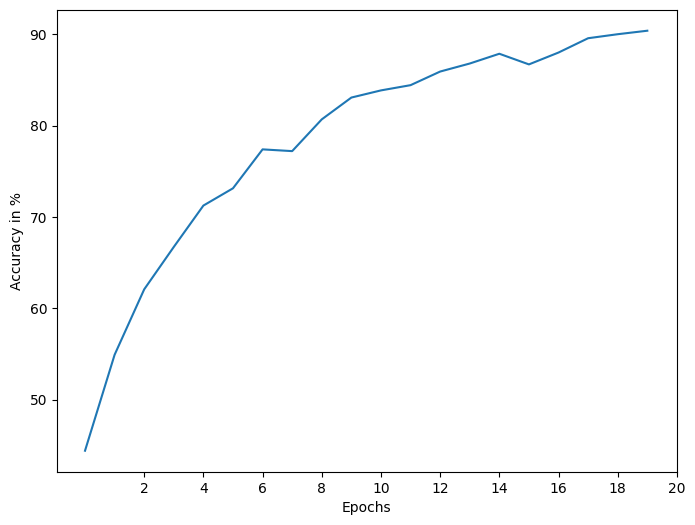

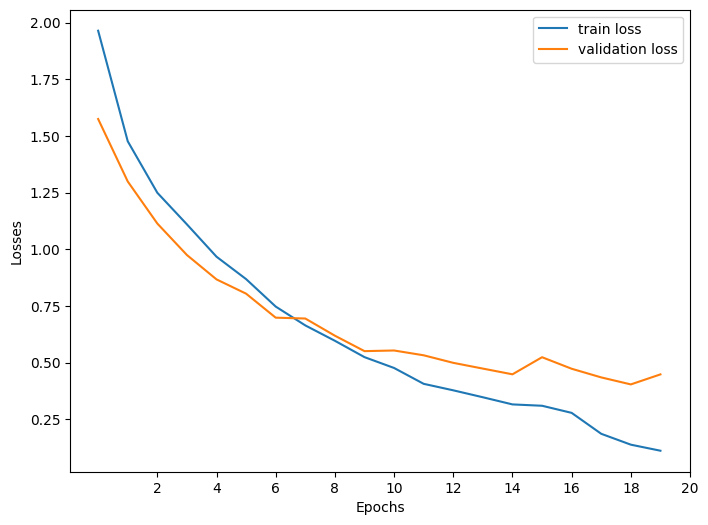

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:21<25:52, 81.73s/it]


epoch:   1, loss: 1.91522, valid loss: 1.62658, valid accruacy: 43.801%
Validation loss decreased (inf --> 1.626580). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:44<24:42, 82.36s/it]


epoch:   2, loss: 1.49916, valid loss: 1.31438, valid accruacy: 55.454%
Validation loss decreased (1.626580 --> 1.314376). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:06<23:20, 82.38s/it]


epoch:   3, loss: 1.24934, valid loss: 1.11914, valid accruacy: 61.566%
Validation loss decreased (1.314376 --> 1.119140). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:29<22:01, 82.58s/it]


epoch:   4, loss: 1.08327, valid loss: 0.98170, valid accruacy: 66.648%
Validation loss decreased (1.119140 --> 0.981702). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [06:52<20:39, 82.63s/it]


epoch:   5, loss: 0.95393, valid loss: 0.88227, valid accruacy: 69.971%
Validation loss decreased (0.981702 --> 0.882269). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:14<19:15, 82.54s/it]


epoch:   6, loss: 0.83135, valid loss: 0.78839, valid accruacy: 72.951%
Validation loss decreased (0.882269 --> 0.788392). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:36<17:49, 82.28s/it]


epoch:   7, loss: 0.71873, valid loss: 0.69896, valid accruacy: 76.772%
Validation loss decreased (0.788392 --> 0.698959). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [10:59<16:28, 82.34s/it]


epoch:   8, loss: 0.61493, valid loss: 0.59543, valid accruacy: 80.554%
Validation loss decreased (0.698959 --> 0.595435). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:21<15:06, 82.42s/it]


epoch:   9, loss: 0.53082, valid loss: 0.57906, valid accruacy: 82.101%
Validation loss decreased (0.595435 --> 0.579064). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [13:44<13:46, 82.62s/it]


epoch:  10, loss: 0.45120, valid loss: 0.54738, valid accruacy: 83.209%
Validation loss decreased (0.579064 --> 0.547383). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [15:07<12:23, 82.57s/it]


epoch:  11, loss: 0.40319, valid loss: 0.48291, valid accruacy: 85.215%
Validation loss decreased (0.547383 --> 0.482911). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [16:28<10:58, 82.25s/it]


epoch:  12, loss: 0.34403, valid loss: 0.46331, valid accruacy: 86.705%
Validation loss decreased (0.482911 --> 0.463305). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [17:50<09:35, 82.18s/it]


epoch:  13, loss: 0.30653, valid loss: 0.44122, valid accruacy: 87.660%
Validation loss decreased (0.463305 --> 0.441217). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [19:12<08:12, 82.09s/it]


epoch:  14, loss: 0.25509, valid loss: 0.45332, valid accruacy: 87.660%


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [20:34<06:49, 81.96s/it]


epoch:  15, loss: 0.24935, valid loss: 0.41913, valid accruacy: 88.481%
Validation loss decreased (0.441217 --> 0.419128). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [21:55<05:27, 81.86s/it]


epoch:  16, loss: 0.20331, valid loss: 0.44745, valid accruacy: 89.226%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [23:17<04:05, 81.85s/it]


epoch:  17, loss: 0.18288, valid loss: 0.43239, valid accruacy: 89.532%
Epoch 00017: reducing learning rate of group 0 to 1.2500e-03.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [24:39<02:43, 81.77s/it]


epoch:  18, loss: 0.13361, valid loss: 0.39833, valid accruacy: 91.041%
Validation loss decreased (0.419128 --> 0.398329). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [26:01<01:21, 82.00s/it]


epoch:  19, loss: 0.08712, valid loss: 0.39639, valid accruacy: 91.194%
Validation loss decreased (0.398329 --> 0.396386). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [27:24<00:00, 82.24s/it]


epoch:  20, loss: 0.07326, valid loss: 0.40187, valid accruacy: 91.098%
Fit time: 1644.8869347572327 s


Test loss: 0.43812	Test accruacy: 91.447%
Saving model


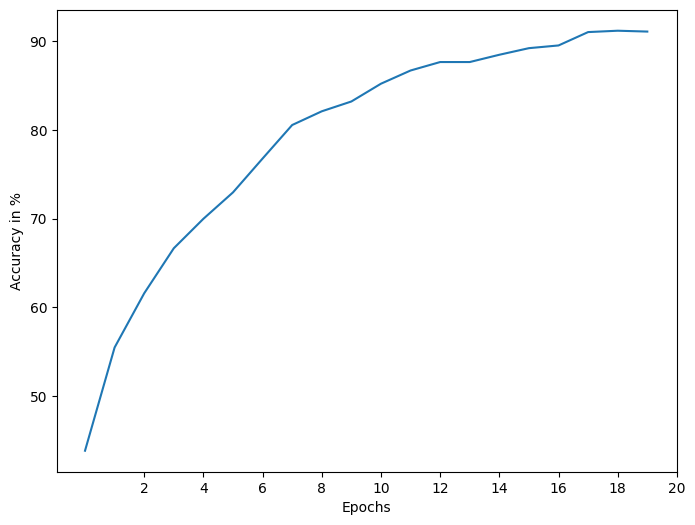

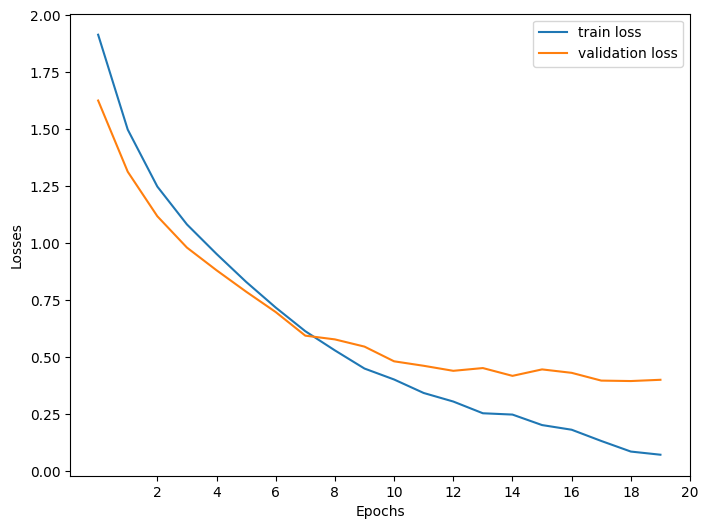

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:22<26:15, 82.92s/it]


epoch:   1, loss: 1.87580, valid loss: 1.58847, valid accruacy: 45.196%
Validation loss decreased (inf --> 1.588469). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:44<24:35, 81.98s/it]


epoch:   2, loss: 1.43951, valid loss: 1.29521, valid accruacy: 55.606%
Validation loss decreased (1.588469 --> 1.295212). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:05<23:09, 81.74s/it]


epoch:   3, loss: 1.20190, valid loss: 1.07666, valid accruacy: 63.018%
Validation loss decreased (1.295212 --> 1.076664). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:27<21:50, 81.91s/it]


epoch:   4, loss: 1.07852, valid loss: 0.96641, valid accruacy: 67.335%
Validation loss decreased (1.076664 --> 0.966412). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [06:48<20:20, 81.39s/it]


epoch:   5, loss: 0.93940, valid loss: 0.83893, valid accruacy: 71.347%
Validation loss decreased (0.966412 --> 0.838926). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:09<19:00, 81.45s/it]


epoch:   6, loss: 0.81286, valid loss: 0.74961, valid accruacy: 75.454%
Validation loss decreased (0.838926 --> 0.749605). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:32<17:42, 81.76s/it]


epoch:   7, loss: 0.71832, valid loss: 0.64710, valid accruacy: 78.816%
Validation loss decreased (0.749605 --> 0.647102). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [10:54<16:21, 81.80s/it]


epoch:   8, loss: 0.60252, valid loss: 0.60838, valid accruacy: 80.860%
Validation loss decreased (0.647102 --> 0.608383). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:15<14:58, 81.71s/it]


epoch:   9, loss: 0.52750, valid loss: 0.58100, valid accruacy: 81.968%
Validation loss decreased (0.608383 --> 0.581005). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [13:37<13:36, 81.62s/it]


epoch:  10, loss: 0.45993, valid loss: 0.50665, valid accruacy: 84.413%
Validation loss decreased (0.581005 --> 0.506647). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [14:58<12:14, 81.60s/it]


epoch:  11, loss: 0.38642, valid loss: 0.47037, valid accruacy: 86.208%
Validation loss decreased (0.506647 --> 0.470375). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [16:20<10:53, 81.66s/it]


epoch:  12, loss: 0.33922, valid loss: 0.47785, valid accruacy: 86.304%


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [17:41<09:30, 81.46s/it]


epoch:  13, loss: 0.28998, valid loss: 0.46827, valid accruacy: 86.590%
Validation loss decreased (0.470375 --> 0.468272). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [19:02<08:08, 81.42s/it]


epoch:  14, loss: 0.27933, valid loss: 0.46599, valid accruacy: 87.755%
Validation loss decreased (0.468272 --> 0.465993). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [20:25<06:48, 81.67s/it]


epoch:  15, loss: 0.22450, valid loss: 0.44417, valid accruacy: 88.520%
Validation loss decreased (0.465993 --> 0.444170). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [21:46<05:26, 81.60s/it]


epoch:  16, loss: 0.21323, valid loss: 0.46280, valid accruacy: 87.908%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [23:07<04:04, 81.46s/it]


epoch:  17, loss: 0.20136, valid loss: 0.49394, valid accruacy: 88.214%
Epoch 00017: reducing learning rate of group 0 to 1.2500e-03.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [24:29<02:42, 81.49s/it]


epoch:  18, loss: 0.12462, valid loss: 0.43435, valid accruacy: 90.353%
Validation loss decreased (0.444170 --> 0.434346). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [25:50<01:21, 81.57s/it]


epoch:  19, loss: 0.09417, valid loss: 0.42447, valid accruacy: 90.487%
Validation loss decreased (0.434346 --> 0.424466). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [27:13<00:00, 81.66s/it]


epoch:  20, loss: 0.07898, valid loss: 0.43574, valid accruacy: 90.812%
Fit time: 1633.1826598644257 s


Test loss: 0.42660	Test accruacy: 91.180%
Saving model


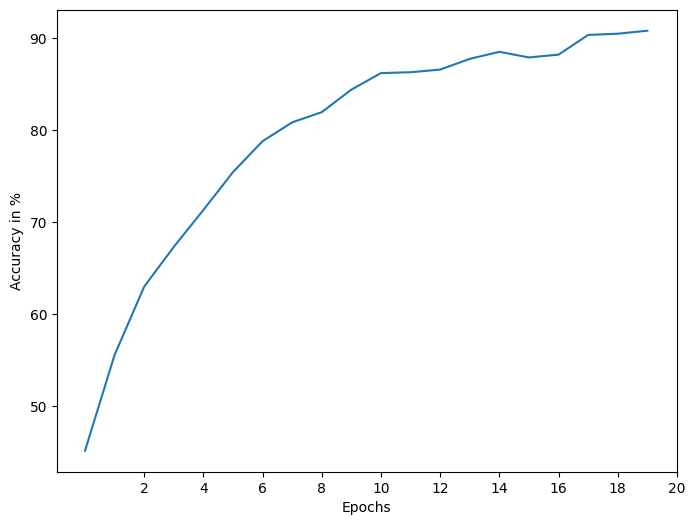

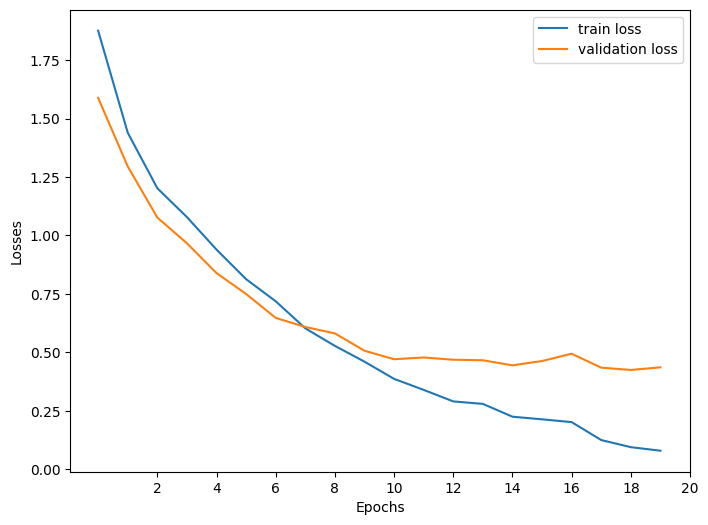

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:22<26:13, 82.81s/it]


epoch:   1, loss: 1.98362, valid loss: 1.76849, valid accruacy: 39.083%
Validation loss decreased (inf --> 1.768491). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:49<25:36, 85.35s/it]


epoch:   2, loss: 1.63804, valid loss: 1.49545, valid accruacy: 48.672%
Validation loss decreased (1.768491 --> 1.495446). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:17<24:24, 86.14s/it]


epoch:   3, loss: 1.41815, valid loss: 1.28230, valid accruacy: 56.294%
Validation loss decreased (1.495446 --> 1.282297). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:39<22:34, 84.66s/it]


epoch:   4, loss: 1.24927, valid loss: 1.15985, valid accruacy: 60.287%
Validation loss decreased (1.282297 --> 1.159848). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:02<21:00, 84.04s/it]


epoch:   5, loss: 1.12992, valid loss: 1.05545, valid accruacy: 64.852%
Validation loss decreased (1.159848 --> 1.055447). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:26<19:37, 84.14s/it]


epoch:   6, loss: 1.02696, valid loss: 0.96247, valid accruacy: 67.393%
Validation loss decreased (1.055447 --> 0.962473). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:52<18:22, 84.81s/it]


epoch:   7, loss: 0.92226, valid loss: 0.87237, valid accruacy: 70.716%
Validation loss decreased (0.962473 --> 0.872375). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [11:15<16:47, 83.99s/it]


epoch:   8, loss: 0.81791, valid loss: 0.78938, valid accruacy: 73.926%
Validation loss decreased (0.872375 --> 0.789382). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:38<15:22, 83.88s/it]


epoch:   9, loss: 0.73796, valid loss: 0.69352, valid accruacy: 77.803%
Validation loss decreased (0.789382 --> 0.693521). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [14:01<13:55, 83.56s/it]


epoch:  10, loss: 0.62668, valid loss: 0.63116, valid accruacy: 79.503%
Validation loss decreased (0.693521 --> 0.631165). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [15:23<12:27, 83.11s/it]


epoch:  11, loss: 0.54846, valid loss: 0.57545, valid accruacy: 81.929%
Validation loss decreased (0.631165 --> 0.575445). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [16:46<11:04, 83.07s/it]


epoch:  12, loss: 0.46188, valid loss: 0.55200, valid accruacy: 83.209%
Validation loss decreased (0.575445 --> 0.552004). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [18:10<09:42, 83.24s/it]


epoch:  13, loss: 0.39878, valid loss: 0.47448, valid accruacy: 85.960%
Validation loss decreased (0.552004 --> 0.474477). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [19:32<08:18, 83.08s/it]


epoch:  14, loss: 0.32966, valid loss: 0.46447, valid accruacy: 86.934%
Validation loss decreased (0.474477 --> 0.464470). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [20:55<06:54, 82.90s/it]


epoch:  15, loss: 0.27452, valid loss: 0.44230, valid accruacy: 87.813%
Validation loss decreased (0.464470 --> 0.442304). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [22:17<05:30, 82.62s/it]


epoch:  16, loss: 0.23930, valid loss: 0.42711, valid accruacy: 88.329%
Validation loss decreased (0.442304 --> 0.427111). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [23:40<04:08, 82.73s/it]


epoch:  17, loss: 0.21724, valid loss: 0.41807, valid accruacy: 89.150%
Validation loss decreased (0.427111 --> 0.418073). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [25:03<02:45, 82.71s/it]


epoch:  18, loss: 0.18303, valid loss: 0.41359, valid accruacy: 89.628%
Validation loss decreased (0.418073 --> 0.413588). Saving model...


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [26:25<01:22, 82.65s/it]


epoch:  19, loss: 0.16389, valid loss: 0.41719, valid accruacy: 89.742%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [28:20<00:00, 85.01s/it]


epoch:  20, loss: 0.13431, valid loss: 0.42798, valid accruacy: 89.990%
Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.
Fit time: 1700.2639079093933 s


Test loss: 0.42580	Test accruacy: 89.920%
Saving model


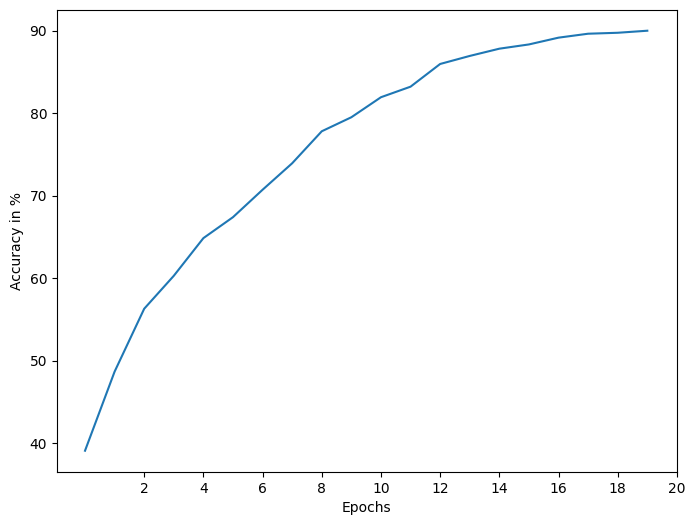

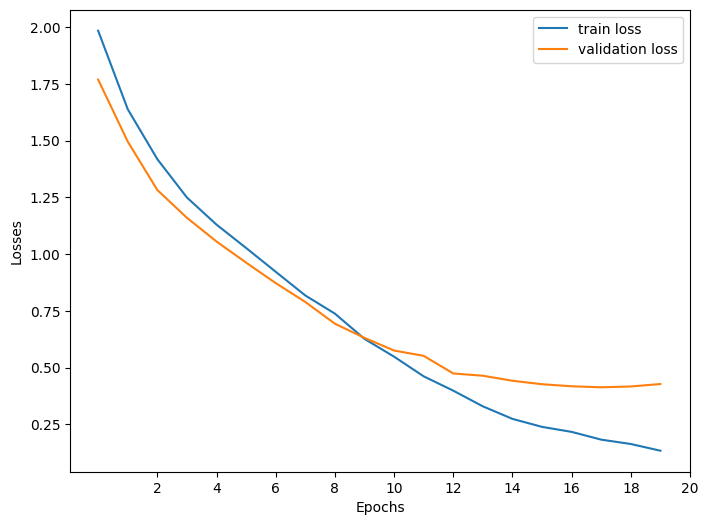

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:33<29:30, 93.21s/it]


epoch:   1, loss: 1.97019, valid loss: 1.68708, valid accruacy: 41.108%
Validation loss decreased (inf --> 1.687079). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:09<28:28, 94.93s/it]


epoch:   2, loss: 1.58108, valid loss: 1.41221, valid accruacy: 51.729%
Validation loss decreased (1.687079 --> 1.412213). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:40<26:21, 93.00s/it]


epoch:   3, loss: 1.37053, valid loss: 1.27242, valid accruacy: 56.141%
Validation loss decreased (1.412213 --> 1.272423). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:26<26:16, 98.51s/it]


epoch:   4, loss: 1.20564, valid loss: 1.11449, valid accruacy: 61.968%
Validation loss decreased (1.272423 --> 1.114495). Saving model...


 25%|████████████████████████████████████████████████▌                                                                                                                                                 | 5/20 [08:27<26:34, 106.30s/it]


epoch:   5, loss: 1.09882, valid loss: 1.02844, valid accruacy: 64.661%
Validation loss decreased (1.114495 --> 1.028441). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 6/20 [10:18<25:12, 108.05s/it]


epoch:   6, loss: 0.99037, valid loss: 0.91164, valid accruacy: 69.016%
Validation loss decreased (1.028441 --> 0.911643). Saving model...


 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                              | 7/20 [12:20<24:23, 112.61s/it]


epoch:   7, loss: 0.88501, valid loss: 0.81791, valid accruacy: 73.219%
Validation loss decreased (0.911643 --> 0.817910). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8/20 [14:26<23:23, 116.94s/it]


epoch:   8, loss: 0.78474, valid loss: 0.73289, valid accruacy: 75.702%
Validation loss decreased (0.817910 --> 0.732885). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9/20 [15:59<20:02, 109.33s/it]


epoch:   9, loss: 0.69013, valid loss: 0.65040, valid accruacy: 79.102%
Validation loss decreased (0.732885 --> 0.650399). Saving model...


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 10/20 [17:34<17:29, 104.91s/it]


epoch:  10, loss: 0.59859, valid loss: 0.61825, valid accruacy: 79.694%
Validation loss decreased (0.650399 --> 0.618251). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 11/20 [19:06<15:09, 101.09s/it]


epoch:  11, loss: 0.51109, valid loss: 0.54226, valid accruacy: 83.477%
Validation loss decreased (0.618251 --> 0.542255). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [20:42<13:16, 99.54s/it]


epoch:  12, loss: 0.41948, valid loss: 0.49991, valid accruacy: 85.177%
Validation loss decreased (0.542255 --> 0.499909). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [22:20<11:32, 98.88s/it]


epoch:  13, loss: 0.35538, valid loss: 0.48820, valid accruacy: 86.208%
Validation loss decreased (0.499909 --> 0.488200). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [23:55<09:46, 97.70s/it]


epoch:  14, loss: 0.31333, valid loss: 0.47845, valid accruacy: 86.495%
Validation loss decreased (0.488200 --> 0.478451). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [25:29<08:02, 96.59s/it]


epoch:  15, loss: 0.26216, valid loss: 0.45015, valid accruacy: 87.641%
Validation loss decreased (0.478451 --> 0.450149). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [26:53<06:11, 92.92s/it]


epoch:  16, loss: 0.21822, valid loss: 0.43447, valid accruacy: 89.112%
Validation loss decreased (0.450149 --> 0.434475). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [28:21<04:34, 91.54s/it]


epoch:  17, loss: 0.19228, valid loss: 0.47355, valid accruacy: 88.309%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [29:54<03:03, 91.85s/it]


epoch:  18, loss: 0.17324, valid loss: 0.46155, valid accruacy: 89.016%
Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [31:36<01:34, 94.79s/it]


epoch:  19, loss: 0.11486, valid loss: 0.43201, valid accruacy: 90.430%
Validation loss decreased (0.434475 --> 0.432013). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [32:58<00:00, 98.93s/it]


epoch:  20, loss: 0.08680, valid loss: 0.42760, valid accruacy: 90.621%
Validation loss decreased (0.432013 --> 0.427596). Saving model...
Fit time: 1978.6085665225983 s


Test loss: 0.44852	Test accruacy: 91.447%
Saving model


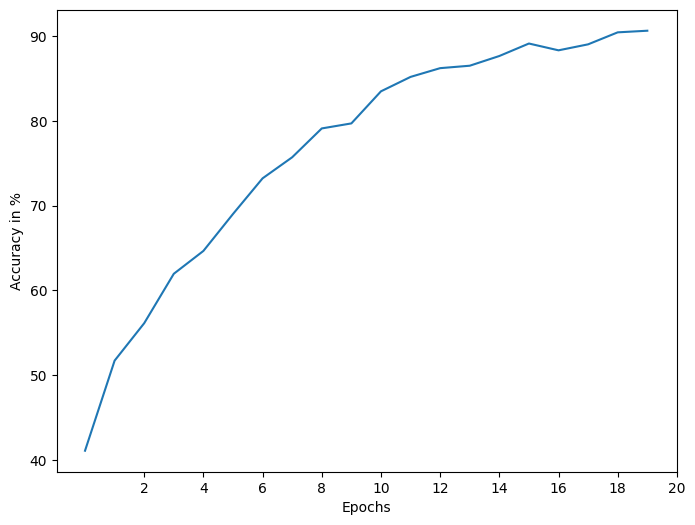

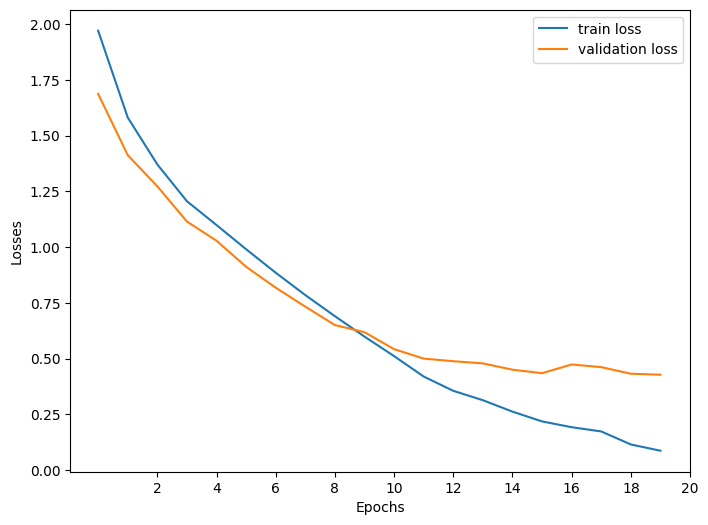

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:24<26:47, 84.59s/it]


epoch:   1, loss: 2.08247, valid loss: 1.78123, valid accruacy: 36.810%
Validation loss decreased (inf --> 1.781234). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:52<25:55, 86.40s/it]


epoch:   2, loss: 1.68009, valid loss: 1.52280, valid accruacy: 47.030%
Validation loss decreased (1.781234 --> 1.522796). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:19<24:34, 86.72s/it]


epoch:   3, loss: 1.47815, valid loss: 1.43439, valid accruacy: 50.735%
Validation loss decreased (1.522796 --> 1.434394). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:42<22:45, 85.36s/it]


epoch:   4, loss: 1.34364, valid loss: 1.25919, valid accruacy: 57.192%
Validation loss decreased (1.434394 --> 1.259188). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:08<21:23, 85.59s/it]


epoch:   5, loss: 1.28464, valid loss: 1.16077, valid accruacy: 60.840%
Validation loss decreased (1.259188 --> 1.160769). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:25<19:18, 82.77s/it]


epoch:   6, loss: 1.21845, valid loss: 1.13843, valid accruacy: 60.172%
Validation loss decreased (1.160769 --> 1.138433). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:47<17:52, 82.52s/it]


epoch:   7, loss: 1.14176, valid loss: 1.20931, valid accruacy: 59.446%


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [10:58<15:45, 78.78s/it]


epoch:   8, loss: 1.11236, valid loss: 0.99694, valid accruacy: 66.762%
Validation loss decreased (1.138433 --> 0.996943). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:10<14:01, 76.53s/it]


epoch:   9, loss: 1.05107, valid loss: 0.93796, valid accruacy: 68.138%
Validation loss decreased (0.996943 --> 0.937955). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [13:33<13:05, 78.60s/it]


epoch:  10, loss: 0.99122, valid loss: 0.90810, valid accruacy: 69.456%
Validation loss decreased (0.937955 --> 0.908099). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [15:11<12:39, 84.41s/it]


epoch:  11, loss: 0.93758, valid loss: 0.88291, valid accruacy: 69.742%
Validation loss decreased (0.908099 --> 0.882914). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [16:36<11:17, 84.67s/it]


epoch:  12, loss: 0.90309, valid loss: 0.89177, valid accruacy: 70.869%


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [17:57<09:44, 83.56s/it]


epoch:  13, loss: 0.87969, valid loss: 0.80200, valid accruacy: 73.582%
Validation loss decreased (0.882914 --> 0.802004). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [19:47<09:09, 91.66s/it]


epoch:  14, loss: 0.82881, valid loss: 0.78059, valid accruacy: 74.728%
Validation loss decreased (0.802004 --> 0.780586). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [21:08<07:22, 88.44s/it]


epoch:  15, loss: 0.80792, valid loss: 0.76527, valid accruacy: 75.664%
Validation loss decreased (0.780586 --> 0.765274). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [22:37<05:54, 88.67s/it]


epoch:  16, loss: 0.77480, valid loss: 0.77695, valid accruacy: 75.033%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [24:28<04:45, 95.29s/it]


epoch:  17, loss: 0.72944, valid loss: 0.68102, valid accruacy: 77.937%
Validation loss decreased (0.765274 --> 0.681015). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [25:59<03:07, 93.97s/it]


epoch:  18, loss: 0.71032, valid loss: 0.71552, valid accruacy: 77.249%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [27:31<01:33, 93.25s/it]


epoch:  19, loss: 0.68558, valid loss: 0.69274, valid accruacy: 78.243%
Epoch 00019: reducing learning rate of group 0 to 2.0000e-03.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [29:05<00:00, 87.29s/it]


epoch:  20, loss: 0.56864, valid loss: 0.60163, valid accruacy: 81.700%
Validation loss decreased (0.681015 --> 0.601631). Saving model...
Fit time: 1745.8050405979156 s


Test loss: 0.59004	Test accruacy: 81.749%
Saving model


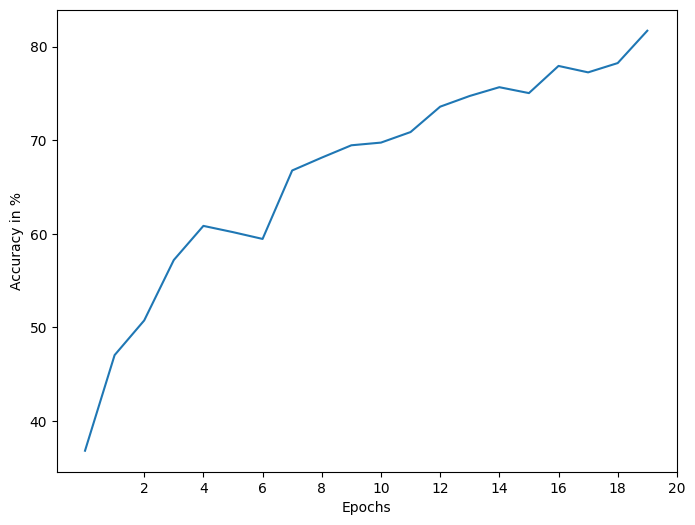

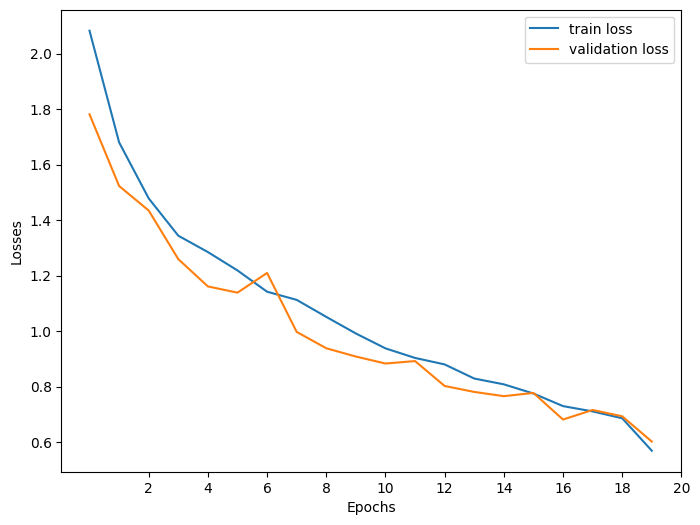

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:33<29:37, 93.53s/it]


epoch:   1, loss: 2.01143, valid loss: 1.75810, valid accruacy: 37.020%
Validation loss decreased (inf --> 1.758100). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:07<28:08, 93.82s/it]


epoch:   2, loss: 1.60240, valid loss: 1.55744, valid accruacy: 48.329%
Validation loss decreased (1.758100 --> 1.557436). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:32<25:24, 89.65s/it]


epoch:   3, loss: 1.37480, valid loss: 1.24092, valid accruacy: 57.899%
Validation loss decreased (1.557436 --> 1.240925). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:51<22:50, 85.69s/it]


epoch:   4, loss: 1.22489, valid loss: 1.09977, valid accruacy: 62.541%
Validation loss decreased (1.240925 --> 1.099771). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:10<20:46, 83.08s/it]


epoch:   5, loss: 1.11808, valid loss: 1.04925, valid accruacy: 64.565%
Validation loss decreased (1.099771 --> 1.049248). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:28<18:59, 81.41s/it]


epoch:   6, loss: 1.04991, valid loss: 1.00748, valid accruacy: 64.604%
Validation loss decreased (1.049248 --> 1.007475). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:43<17:11, 79.36s/it]


epoch:   7, loss: 0.98789, valid loss: 0.93939, valid accruacy: 68.138%
Validation loss decreased (1.007475 --> 0.939395). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [11:11<16:23, 81.93s/it]


epoch:   8, loss: 0.92858, valid loss: 0.93918, valid accruacy: 68.615%
Validation loss decreased (0.939395 --> 0.939184). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:41<15:29, 84.53s/it]


epoch:   9, loss: 0.88464, valid loss: 0.83010, valid accruacy: 72.340%
Validation loss decreased (0.939184 --> 0.830097). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [14:13<14:28, 86.85s/it]


epoch:  10, loss: 0.83713, valid loss: 0.87299, valid accruacy: 70.984%


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [15:42<13:08, 87.57s/it]


epoch:  11, loss: 0.77872, valid loss: 0.75647, valid accruacy: 74.422%
Validation loss decreased (0.830097 --> 0.756467). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [17:07<11:33, 86.66s/it]


epoch:  12, loss: 0.75297, valid loss: 0.76744, valid accruacy: 74.690%


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [18:39<10:18, 88.32s/it]


epoch:  13, loss: 0.68205, valid loss: 0.69058, valid accruacy: 77.307%
Validation loss decreased (0.756467 --> 0.690582). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [20:13<09:00, 90.07s/it]


epoch:  14, loss: 0.68358, valid loss: 0.71552, valid accruacy: 76.867%


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [21:42<07:29, 89.81s/it]


epoch:  15, loss: 0.64363, valid loss: 0.64125, valid accruacy: 79.713%
Validation loss decreased (0.690582 --> 0.641246). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [23:09<05:55, 88.89s/it]


epoch:  16, loss: 0.60173, valid loss: 0.65368, valid accruacy: 79.140%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [24:38<04:27, 89.06s/it]


epoch:  17, loss: 0.57491, valid loss: 0.59619, valid accruacy: 81.394%
Validation loss decreased (0.641246 --> 0.596193). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [26:40<03:17, 98.87s/it]


epoch:  18, loss: 0.53194, valid loss: 0.67975, valid accruacy: 79.312%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [28:11<01:36, 96.56s/it]


epoch:  19, loss: 0.54864, valid loss: 0.56181, valid accruacy: 82.464%
Validation loss decreased (0.596193 --> 0.561810). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [29:41<00:00, 89.06s/it]


epoch:  20, loss: 0.51188, valid loss: 0.56841, valid accruacy: 83.477%
Fit time: 1781.2247858047485 s


Test loss: 0.62605	Test accruacy: 80.031%
Saving model


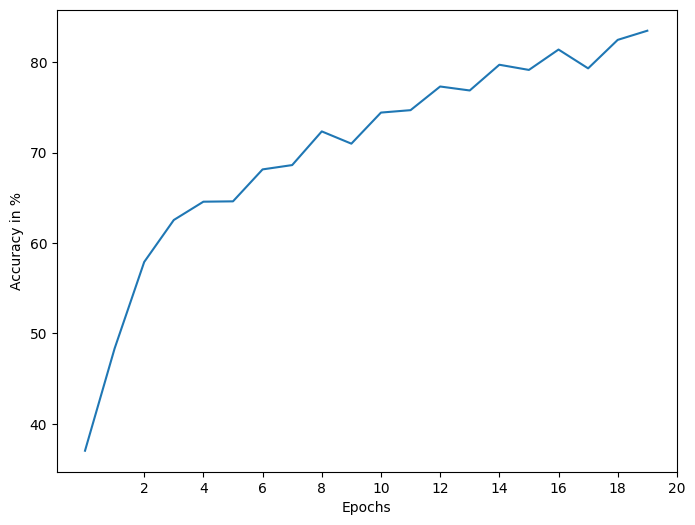

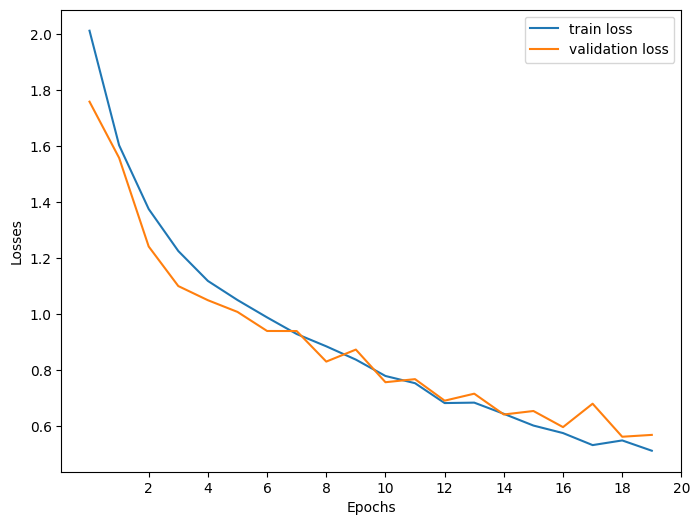

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:14<23:36, 74.55s/it]


epoch:   1, loss: 1.97579, valid loss: 1.68345, valid accruacy: 40.936%
Validation loss decreased (inf --> 1.683448). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:25<21:48, 72.71s/it]


epoch:   2, loss: 1.50887, valid loss: 1.33572, valid accruacy: 53.047%
Validation loss decreased (1.683448 --> 1.335725). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:37<20:24, 72.04s/it]


epoch:   3, loss: 1.28958, valid loss: 1.15289, valid accruacy: 60.611%
Validation loss decreased (1.335725 --> 1.152888). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:49<19:13, 72.08s/it]


epoch:   4, loss: 1.14650, valid loss: 1.02918, valid accruacy: 63.801%
Validation loss decreased (1.152888 --> 1.029176). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [06:02<18:05, 72.36s/it]


epoch:   5, loss: 1.04273, valid loss: 0.96802, valid accruacy: 66.533%
Validation loss decreased (1.029176 --> 0.968018). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:14<16:52, 72.30s/it]


epoch:   6, loss: 0.96044, valid loss: 0.92151, valid accruacy: 68.080%
Validation loss decreased (0.968018 --> 0.921507). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:24<15:32, 71.71s/it]


epoch:   7, loss: 0.87525, valid loss: 0.80519, valid accruacy: 72.474%
Validation loss decreased (0.921507 --> 0.805189). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:36<14:19, 71.64s/it]


epoch:   8, loss: 0.79787, valid loss: 0.74385, valid accruacy: 74.422%
Validation loss decreased (0.805189 --> 0.743850). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:47<13:07, 71.59s/it]


epoch:   9, loss: 0.73822, valid loss: 0.74119, valid accruacy: 74.747%
Validation loss decreased (0.743850 --> 0.741195). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [12:01<12:01, 72.14s/it]


epoch:  10, loss: 0.67667, valid loss: 0.68017, valid accruacy: 77.173%
Validation loss decreased (0.741195 --> 0.680170). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [13:11<10:44, 71.67s/it]


epoch:  11, loss: 0.62619, valid loss: 0.68127, valid accruacy: 77.841%


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:23<09:33, 71.64s/it]


epoch:  12, loss: 0.57680, valid loss: 0.59650, valid accruacy: 80.630%
Validation loss decreased (0.680170 --> 0.596503). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [15:34<08:21, 71.60s/it]


epoch:  13, loss: 0.53095, valid loss: 0.52388, valid accruacy: 83.687%
Validation loss decreased (0.596503 --> 0.523878). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [16:46<07:10, 71.71s/it]


epoch:  14, loss: 0.47822, valid loss: 0.53640, valid accruacy: 83.228%


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [18:12<06:19, 75.96s/it]


epoch:  15, loss: 0.45259, valid loss: 0.51672, valid accruacy: 84.260%
Validation loss decreased (0.523878 --> 0.516718). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [19:43<05:21, 80.45s/it]


epoch:  16, loss: 0.40625, valid loss: 0.48536, valid accruacy: 85.635%
Validation loss decreased (0.516718 --> 0.485356). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [21:12<04:08, 82.91s/it]


epoch:  17, loss: 0.37133, valid loss: 0.48573, valid accruacy: 85.883%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [22:57<02:59, 89.75s/it]


epoch:  18, loss: 0.34431, valid loss: 0.52607, valid accruacy: 85.540%
Epoch 00018: reducing learning rate of group 0 to 1.2500e-03.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [24:56<01:38, 98.50s/it]


epoch:  19, loss: 0.24136, valid loss: 0.42364, valid accruacy: 89.150%
Validation loss decreased (0.485356 --> 0.423638). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [26:56<00:00, 80.83s/it]


epoch:  20, loss: 0.18763, valid loss: 0.41391, valid accruacy: 89.532%
Validation loss decreased (0.423638 --> 0.413914). Saving model...
Fit time: 1616.5117456912994 s


Test loss: 0.41088	Test accruacy: 90.187%
Saving model


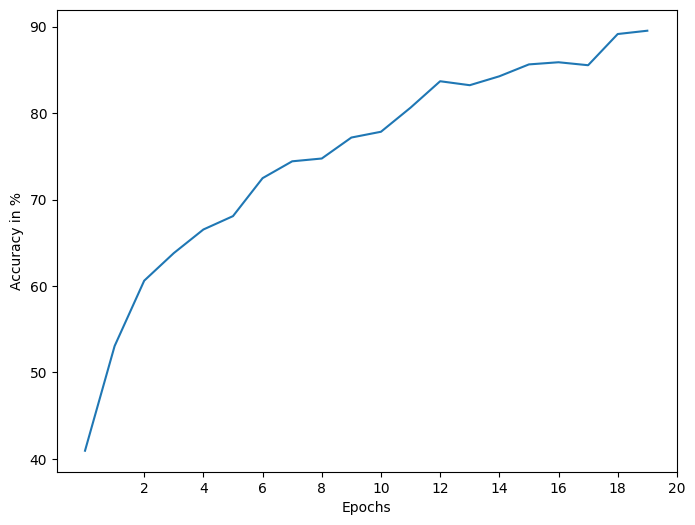

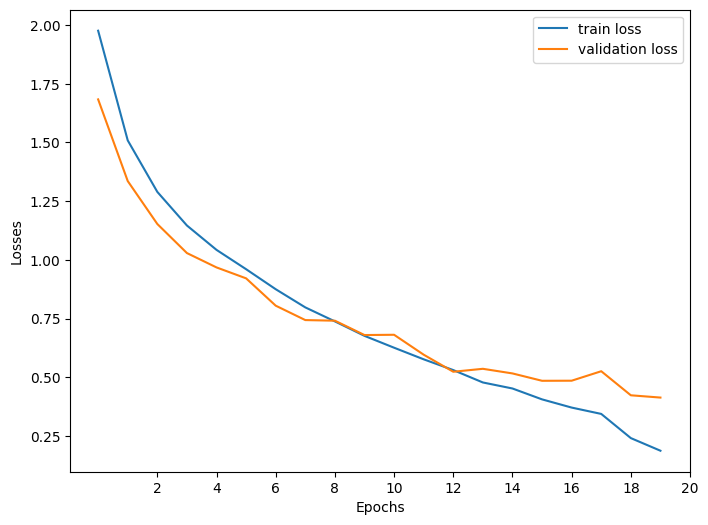

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:26<27:32, 86.98s/it]


epoch:   1, loss: 1.99181, valid loss: 1.84584, valid accruacy: 33.868%
Validation loss decreased (inf --> 1.845836). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:54<26:09, 87.18s/it]


epoch:   2, loss: 1.51784, valid loss: 1.32744, valid accruacy: 55.473%
Validation loss decreased (1.845836 --> 1.327445). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:32<26:06, 92.12s/it]


epoch:   3, loss: 1.26341, valid loss: 1.16831, valid accruacy: 59.580%
Validation loss decreased (1.327445 --> 1.168307). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:01<24:12, 90.81s/it]


epoch:   4, loss: 1.12152, valid loss: 1.02569, valid accruacy: 64.642%
Validation loss decreased (1.168307 --> 1.025692). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:54<24:46, 99.10s/it]


epoch:   5, loss: 0.99700, valid loss: 0.88059, valid accruacy: 70.277%
Validation loss decreased (1.025692 --> 0.880589). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [09:32<22:59, 98.56s/it]


epoch:   6, loss: 0.89271, valid loss: 0.86091, valid accruacy: 71.805%
Validation loss decreased (0.880589 --> 0.860913). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [11:10<21:18, 98.31s/it]


epoch:   7, loss: 0.82556, valid loss: 0.79010, valid accruacy: 73.410%
Validation loss decreased (0.860913 --> 0.790100). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8/20 [12:59<20:22, 101.89s/it]


epoch:   8, loss: 0.74140, valid loss: 0.68813, valid accruacy: 76.619%
Validation loss decreased (0.790100 --> 0.688130). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [14:35<18:18, 99.89s/it]


epoch:   9, loss: 0.66778, valid loss: 0.65811, valid accruacy: 77.899%
Validation loss decreased (0.688130 --> 0.658107). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [16:04<16:05, 96.51s/it]


epoch:  10, loss: 0.60130, valid loss: 0.60632, valid accruacy: 80.573%
Validation loss decreased (0.658107 --> 0.606322). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [17:36<14:16, 95.18s/it]


epoch:  11, loss: 0.54210, valid loss: 0.59708, valid accruacy: 81.242%
Validation loss decreased (0.606322 --> 0.597082). Saving model...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 12/20 [19:40<13:52, 104.02s/it]


epoch:  12, loss: 0.48894, valid loss: 0.52769, valid accruacy: 83.610%
Validation loss decreased (0.597082 --> 0.527686). Saving model...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 13/20 [21:45<12:52, 110.38s/it]


epoch:  13, loss: 0.44329, valid loss: 0.49935, valid accruacy: 84.336%
Validation loss decreased (0.527686 --> 0.499345). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 14/20 [23:44<11:17, 112.90s/it]


epoch:  14, loss: 0.39800, valid loss: 0.45625, valid accruacy: 86.285%
Validation loss decreased (0.499345 --> 0.456250). Saving model...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 15/20 [25:47<09:39, 115.95s/it]


epoch:  15, loss: 0.35731, valid loss: 0.48199, valid accruacy: 86.074%


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 16/20 [28:03<08:07, 121.93s/it]


epoch:  16, loss: 0.34569, valid loss: 0.49194, valid accruacy: 86.571%
Epoch 00016: reducing learning rate of group 0 to 1.2500e-03.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 17/20 [30:16<06:16, 125.48s/it]


epoch:  17, loss: 0.23162, valid loss: 0.40244, valid accruacy: 89.666%
Validation loss decreased (0.456250 --> 0.402438). Saving model...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 18/20 [32:29<04:14, 127.50s/it]


epoch:  18, loss: 0.17992, valid loss: 0.39886, valid accruacy: 90.105%
Validation loss decreased (0.402438 --> 0.398861). Saving model...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [34:46<02:10, 130.48s/it]


epoch:  19, loss: 0.16457, valid loss: 0.42676, valid accruacy: 89.761%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [37:03<00:00, 111.17s/it]


epoch:  20, loss: 0.14812, valid loss: 0.41493, valid accruacy: 90.258%
Epoch 00020: reducing learning rate of group 0 to 6.2500e-04.
Fit time: 2223.3935585021973 s


Test loss: 0.44071	Test accruacy: 89.156%
Saving model


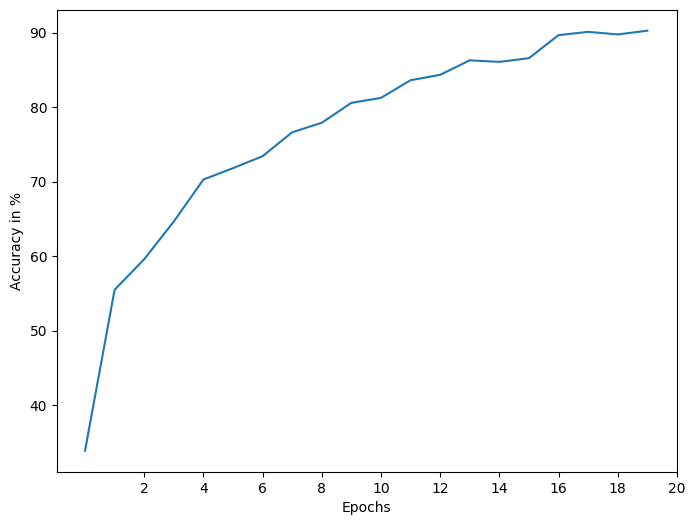

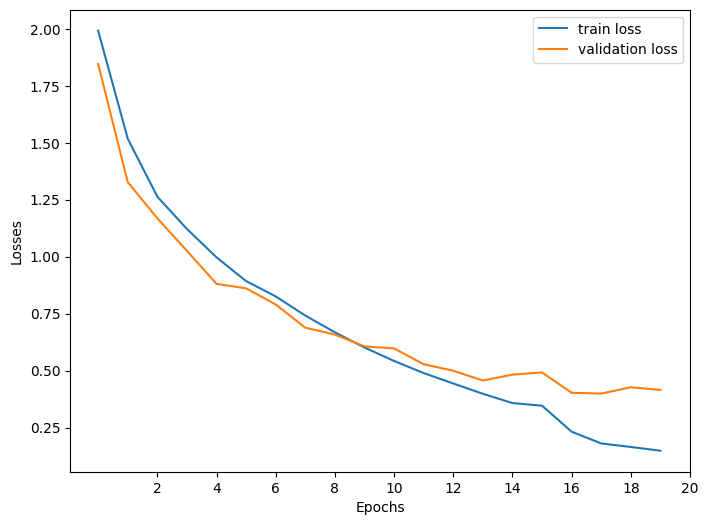

results were saved to csv

Fitting nn model


  5%|█████████▋                                                                                                                                                                                        | 1/20 [02:12<42:04, 132.85s/it]


epoch:   1, loss: 1.90410, valid loss: 1.66271, valid accruacy: 43.610%
Validation loss decreased (inf --> 1.662711). Saving model...


 10%|███████████████████▍                                                                                                                                                                              | 2/20 [04:26<39:56, 133.16s/it]


epoch:   2, loss: 1.46877, valid loss: 1.27639, valid accruacy: 56.772%
Validation loss decreased (1.662711 --> 1.276389). Saving model...


 15%|█████████████████████████████                                                                                                                                                                     | 3/20 [06:39<37:48, 133.43s/it]


epoch:   3, loss: 1.25495, valid loss: 1.20982, valid accruacy: 58.109%
Validation loss decreased (1.276389 --> 1.209823). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 4/20 [08:54<35:43, 133.95s/it]


epoch:   4, loss: 1.11668, valid loss: 1.00623, valid accruacy: 65.578%
Validation loss decreased (1.209823 --> 1.006227). Saving model...


 25%|████████████████████████████████████████████████▌                                                                                                                                                 | 5/20 [10:48<31:41, 126.75s/it]


epoch:   5, loss: 1.01244, valid loss: 0.90608, valid accruacy: 69.532%
Validation loss decreased (1.006227 --> 0.906084). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 6/20 [12:16<26:29, 113.56s/it]


epoch:   6, loss: 0.92147, valid loss: 0.89886, valid accruacy: 69.914%
Validation loss decreased (0.906084 --> 0.898861). Saving model...


 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                              | 7/20 [13:45<22:49, 105.36s/it]


epoch:   7, loss: 0.82957, valid loss: 0.89657, valid accruacy: 69.284%
Validation loss decreased (0.898861 --> 0.896569). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8/20 [15:22<20:32, 102.68s/it]


epoch:   8, loss: 0.74334, valid loss: 0.74040, valid accruacy: 75.244%
Validation loss decreased (0.896569 --> 0.740401). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9/20 [17:11<19:12, 104.80s/it]


epoch:   9, loss: 0.66529, valid loss: 0.65125, valid accruacy: 78.434%
Validation loss decreased (0.740401 --> 0.651248). Saving model...


 50%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 10/20 [18:40<16:40, 100.04s/it]


epoch:  10, loss: 0.58575, valid loss: 0.59962, valid accruacy: 80.478%
Validation loss decreased (0.651248 --> 0.599621). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [20:07<14:22, 95.84s/it]


epoch:  11, loss: 0.51939, valid loss: 0.56523, valid accruacy: 81.987%
Validation loss decreased (0.599621 --> 0.565227). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [21:35<12:28, 93.62s/it]


epoch:  12, loss: 0.43377, valid loss: 0.52780, valid accruacy: 83.916%
Validation loss decreased (0.565227 --> 0.527797). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [23:03<10:42, 91.80s/it]


epoch:  13, loss: 0.39547, valid loss: 0.52039, valid accruacy: 84.470%
Validation loss decreased (0.527797 --> 0.520385). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [24:30<09:01, 90.29s/it]


epoch:  14, loss: 0.34432, valid loss: 0.50358, valid accruacy: 85.654%
Validation loss decreased (0.520385 --> 0.503581). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [25:57<07:26, 89.25s/it]


epoch:  15, loss: 0.28844, valid loss: 0.47348, valid accruacy: 87.335%
Validation loss decreased (0.503581 --> 0.473483). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [27:25<05:55, 88.95s/it]


epoch:  16, loss: 0.24639, valid loss: 0.46873, valid accruacy: 88.042%
Validation loss decreased (0.473483 --> 0.468729). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [28:53<04:26, 88.73s/it]


epoch:  17, loss: 0.22922, valid loss: 0.47147, valid accruacy: 87.450%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [30:29<03:02, 91.00s/it]


epoch:  18, loss: 0.20894, valid loss: 0.46887, valid accruacy: 87.889%
Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [32:03<01:31, 91.93s/it]


epoch:  19, loss: 0.13529, valid loss: 0.43907, valid accruacy: 90.181%
Validation loss decreased (0.468729 --> 0.439071). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [33:31<00:00, 100.60s/it]


epoch:  20, loss: 0.09659, valid loss: 0.44639, valid accruacy: 90.659%
Fit time: 2011.9829683303833 s


Test loss: 0.49010	Test accruacy: 89.920%
Saving model


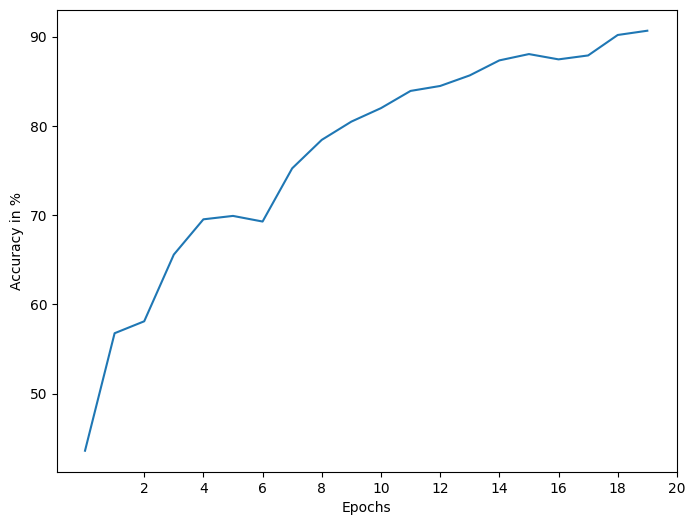

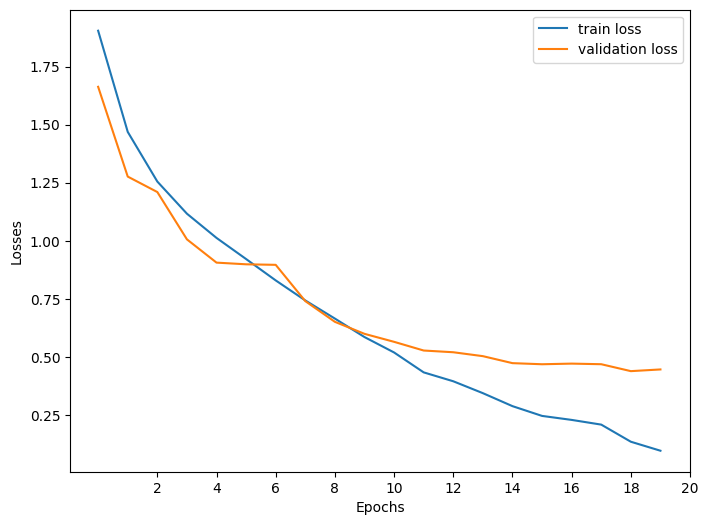

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:25<27:13, 85.95s/it]


epoch:   1, loss: 1.95146, valid loss: 1.63188, valid accruacy: 43.419%
Validation loss decreased (inf --> 1.631879). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:56<26:40, 88.92s/it]


epoch:   2, loss: 1.49786, valid loss: 1.30739, valid accruacy: 55.492%
Validation loss decreased (1.631879 --> 1.307392). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:24<24:57, 88.08s/it]


epoch:   3, loss: 1.26976, valid loss: 1.14318, valid accruacy: 60.287%
Validation loss decreased (1.307392 --> 1.143184). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [05:53<23:37, 88.57s/it]


epoch:   4, loss: 1.11423, valid loss: 1.00743, valid accruacy: 65.979%
Validation loss decreased (1.143184 --> 1.007431). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:20<22:01, 88.12s/it]


epoch:   5, loss: 1.01590, valid loss: 0.90776, valid accruacy: 69.150%
Validation loss decreased (1.007431 --> 0.907759). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:54<21:02, 90.20s/it]


epoch:   6, loss: 0.91699, valid loss: 0.86716, valid accruacy: 70.086%
Validation loss decreased (0.907759 --> 0.867159). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [10:23<19:24, 89.61s/it]


epoch:   7, loss: 0.84526, valid loss: 0.79456, valid accruacy: 73.009%
Validation loss decreased (0.867159 --> 0.794562). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [11:51<17:50, 89.23s/it]


epoch:   8, loss: 0.74367, valid loss: 0.70709, valid accruacy: 75.836%
Validation loss decreased (0.794562 --> 0.707090). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [13:22<16:28, 89.86s/it]


epoch:   9, loss: 0.67508, valid loss: 0.62789, valid accruacy: 79.045%
Validation loss decreased (0.707090 --> 0.627889). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [14:57<15:12, 91.25s/it]


epoch:  10, loss: 0.60464, valid loss: 0.61223, valid accruacy: 79.924%
Validation loss decreased (0.627889 --> 0.612227). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [16:37<14:06, 94.02s/it]


epoch:  11, loss: 0.52254, valid loss: 0.53424, valid accruacy: 82.999%
Validation loss decreased (0.612227 --> 0.534239). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [18:14<12:40, 95.03s/it]


epoch:  12, loss: 0.45507, valid loss: 0.48174, valid accruacy: 84.890%
Validation loss decreased (0.534239 --> 0.481741). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [19:41<10:47, 92.56s/it]


epoch:  13, loss: 0.39980, valid loss: 0.49071, valid accruacy: 85.444%


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [21:26<09:37, 96.20s/it]


epoch:  14, loss: 0.35484, valid loss: 0.48452, valid accruacy: 86.418%
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 15/20 [23:20<08:28, 101.63s/it]


epoch:  15, loss: 0.23842, valid loss: 0.40067, valid accruacy: 89.417%
Validation loss decreased (0.481741 --> 0.400667). Saving model...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 16/20 [25:00<06:44, 101.10s/it]


epoch:  16, loss: 0.19180, valid loss: 0.41575, valid accruacy: 89.016%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [26:19<04:43, 94.34s/it]


epoch:  17, loss: 0.16215, valid loss: 0.39376, valid accruacy: 90.850%
Validation loss decreased (0.400667 --> 0.393761). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [27:53<03:08, 94.47s/it]


epoch:  18, loss: 0.14693, valid loss: 0.42028, valid accruacy: 90.067%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [29:39<01:37, 97.66s/it]


epoch:  19, loss: 0.13640, valid loss: 0.41519, valid accruacy: 90.468%
Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [31:05<00:00, 93.29s/it]


epoch:  20, loss: 0.09599, valid loss: 0.37855, valid accruacy: 91.939%
Validation loss decreased (0.393761 --> 0.378550). Saving model...
Fit time: 1865.8724992275238 s


Test loss: 0.41883	Test accruacy: 89.958%
Saving model


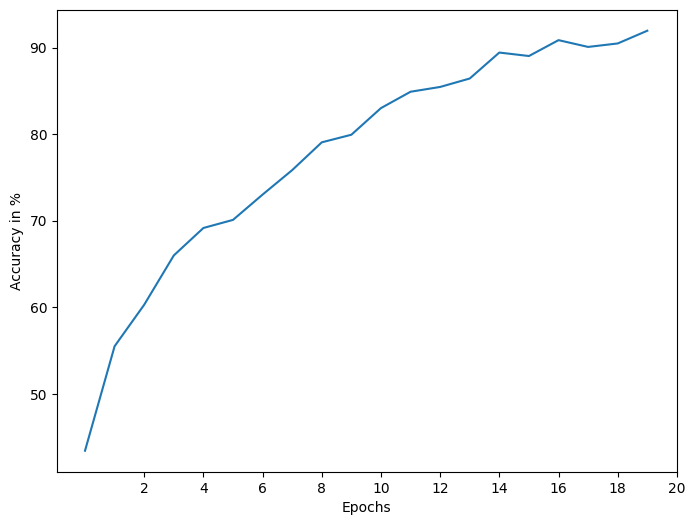

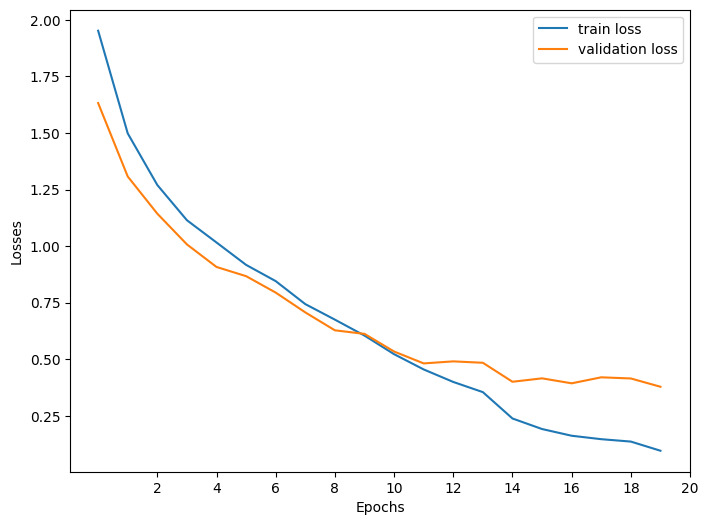

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:16<24:12, 76.45s/it]


epoch:   1, loss: 2.05574, valid loss: 1.79559, valid accruacy: 35.053%
Validation loss decreased (inf --> 1.795587). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:28<22:08, 73.83s/it]


epoch:   2, loss: 1.70104, valid loss: 1.45408, valid accruacy: 48.863%
Validation loss decreased (1.795587 --> 1.454081). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:40<20:42, 73.09s/it]


epoch:   3, loss: 1.44336, valid loss: 1.28712, valid accruacy: 55.186%
Validation loss decreased (1.454081 --> 1.287125). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:51<19:16, 72.31s/it]


epoch:   4, loss: 1.30517, valid loss: 1.19713, valid accruacy: 57.899%
Validation loss decreased (1.287125 --> 1.197134). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [06:02<17:58, 71.88s/it]


epoch:   5, loss: 1.19332, valid loss: 1.13587, valid accruacy: 60.363%
Validation loss decreased (1.197134 --> 1.135865). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:14<16:45, 71.85s/it]


epoch:   6, loss: 1.10129, valid loss: 1.04700, valid accruacy: 63.916%
Validation loss decreased (1.135865 --> 1.046997). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:25<15:31, 71.62s/it]


epoch:   7, loss: 1.02314, valid loss: 0.93784, valid accruacy: 68.615%
Validation loss decreased (1.046997 --> 0.937843). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:37<14:19, 71.65s/it]


epoch:   8, loss: 0.94497, valid loss: 0.89397, valid accruacy: 69.207%
Validation loss decreased (0.937843 --> 0.893974). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:48<13:07, 71.56s/it]


epoch:   9, loss: 0.88591, valid loss: 0.84016, valid accruacy: 71.614%
Validation loss decreased (0.893974 --> 0.840159). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [12:00<11:55, 71.57s/it]


epoch:  10, loss: 0.81267, valid loss: 0.76644, valid accruacy: 73.715%
Validation loss decreased (0.840159 --> 0.766444). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [13:11<10:41, 71.27s/it]


epoch:  11, loss: 0.76299, valid loss: 0.73698, valid accruacy: 75.396%
Validation loss decreased (0.766444 --> 0.736977). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:21<09:28, 71.08s/it]


epoch:  12, loss: 0.69184, valid loss: 0.67021, valid accruacy: 78.243%
Validation loss decreased (0.736977 --> 0.670208). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [15:33<08:18, 71.17s/it]


epoch:  13, loss: 0.63901, valid loss: 0.63930, valid accruacy: 78.625%
Validation loss decreased (0.670208 --> 0.639296). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [16:44<07:07, 71.29s/it]


epoch:  14, loss: 0.57878, valid loss: 0.60832, valid accruacy: 80.630%
Validation loss decreased (0.639296 --> 0.608322). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [17:56<05:56, 71.38s/it]


epoch:  15, loss: 0.54651, valid loss: 0.59443, valid accruacy: 80.955%
Validation loss decreased (0.608322 --> 0.594432). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [19:08<04:46, 71.61s/it]


epoch:  16, loss: 0.53175, valid loss: 0.55154, valid accruacy: 82.369%
Validation loss decreased (0.594432 --> 0.551542). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [20:18<03:33, 71.20s/it]


epoch:  17, loss: 0.48791, valid loss: 0.55242, valid accruacy: 82.713%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [21:28<02:21, 70.94s/it]


epoch:  18, loss: 0.44514, valid loss: 0.56528, valid accruacy: 82.579%
Epoch 00018: reducing learning rate of group 0 to 2.0000e-03.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [22:38<01:10, 70.64s/it]


epoch:  19, loss: 0.34703, valid loss: 0.44319, valid accruacy: 87.144%
Validation loss decreased (0.551542 --> 0.443193). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:49<00:00, 71.45s/it]


epoch:  20, loss: 0.27672, valid loss: 0.42248, valid accruacy: 88.329%
Validation loss decreased (0.443193 --> 0.422484). Saving model...
Fit time: 1429.056617975235 s


Test loss: 0.45055	Test accruacy: 88.851%
Saving model


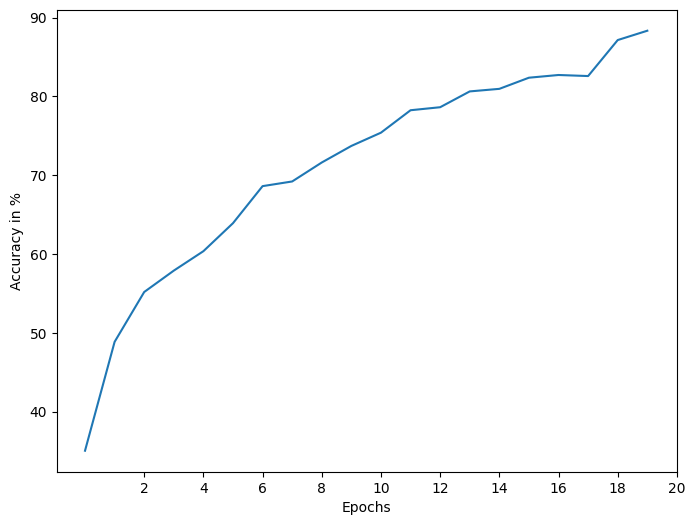

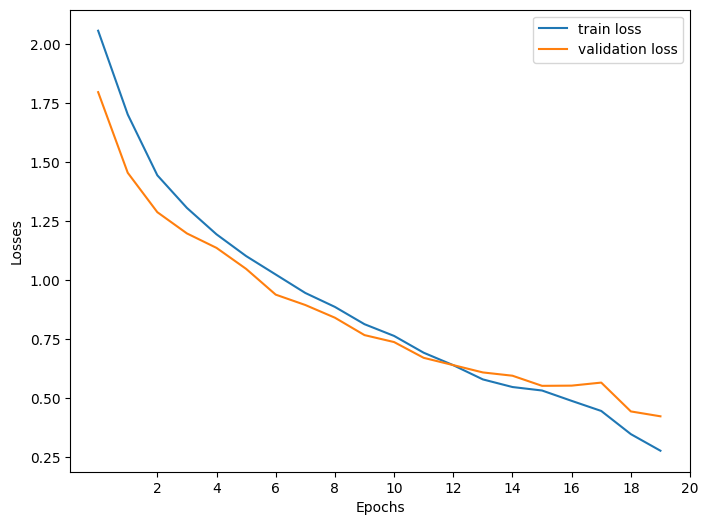

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:10<22:24, 70.76s/it]


epoch:   1, loss: 2.05573, valid loss: 1.74394, valid accruacy: 38.453%
Validation loss decreased (inf --> 1.743935). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:23<21:31, 71.75s/it]


epoch:   2, loss: 1.62212, valid loss: 1.37903, valid accruacy: 52.646%
Validation loss decreased (1.743935 --> 1.379026). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:33<20:10, 71.18s/it]


epoch:   3, loss: 1.38805, valid loss: 1.20554, valid accruacy: 58.873%
Validation loss decreased (1.379026 --> 1.205544). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:44<18:55, 70.96s/it]


epoch:   4, loss: 1.22770, valid loss: 1.06487, valid accruacy: 63.286%
Validation loss decreased (1.205544 --> 1.064874). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:54<17:41, 70.75s/it]


epoch:   5, loss: 1.10627, valid loss: 1.05023, valid accruacy: 63.878%
Validation loss decreased (1.064874 --> 1.050233). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:05<16:28, 70.63s/it]


epoch:   6, loss: 1.02457, valid loss: 0.93154, valid accruacy: 67.584%
Validation loss decreased (1.050233 --> 0.931536). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:16<15:20, 70.79s/it]


epoch:   7, loss: 0.93606, valid loss: 0.90736, valid accruacy: 69.054%
Validation loss decreased (0.931536 --> 0.907363). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:26<14:07, 70.65s/it]


epoch:   8, loss: 0.87337, valid loss: 0.80439, valid accruacy: 72.588%
Validation loss decreased (0.907363 --> 0.804390). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:36<12:54, 70.44s/it]


epoch:   9, loss: 0.81560, valid loss: 0.73645, valid accruacy: 75.110%
Validation loss decreased (0.804390 --> 0.736450). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:49<11:52, 71.27s/it]


epoch:  10, loss: 0.74211, valid loss: 0.74428, valid accruacy: 75.798%


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [12:59<10:38, 70.98s/it]


epoch:  11, loss: 0.69039, valid loss: 0.69597, valid accruacy: 76.982%
Validation loss decreased (0.736450 --> 0.695972). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:10<09:27, 70.96s/it]


epoch:  12, loss: 0.61681, valid loss: 0.63864, valid accruacy: 79.522%
Validation loss decreased (0.695972 --> 0.638635). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [15:20<08:14, 70.64s/it]


epoch:  13, loss: 0.56793, valid loss: 0.59395, valid accruacy: 81.089%
Validation loss decreased (0.638635 --> 0.593951). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [16:30<07:02, 70.44s/it]


epoch:  14, loss: 0.54086, valid loss: 0.65410, valid accruacy: 79.694%


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [17:41<05:52, 70.49s/it]


epoch:  15, loss: 0.49364, valid loss: 0.57625, valid accruacy: 82.025%
Validation loss decreased (0.593951 --> 0.576250). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [18:51<04:41, 70.38s/it]


epoch:  16, loss: 0.45016, valid loss: 0.55038, valid accruacy: 83.763%
Validation loss decreased (0.576250 --> 0.550382). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [20:01<03:30, 70.30s/it]


epoch:  17, loss: 0.42429, valid loss: 0.52673, valid accruacy: 84.011%
Validation loss decreased (0.550382 --> 0.526733). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [21:12<02:21, 70.52s/it]


epoch:  18, loss: 0.37499, valid loss: 0.54327, valid accruacy: 84.508%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [22:23<01:10, 70.60s/it]


epoch:  19, loss: 0.35551, valid loss: 0.53101, valid accruacy: 84.317%
Epoch 00019: reducing learning rate of group 0 to 2.0000e-03.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:33<00:00, 70.69s/it]


epoch:  20, loss: 0.26534, valid loss: 0.45505, valid accruacy: 87.717%
Validation loss decreased (0.526733 --> 0.455051). Saving model...
Fit time: 1413.81574344635 s


Test loss: 0.47138	Test accruacy: 87.629%
Saving model


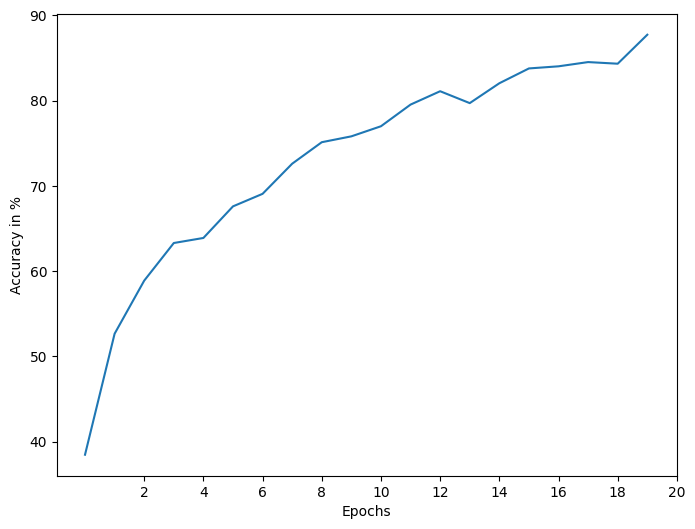

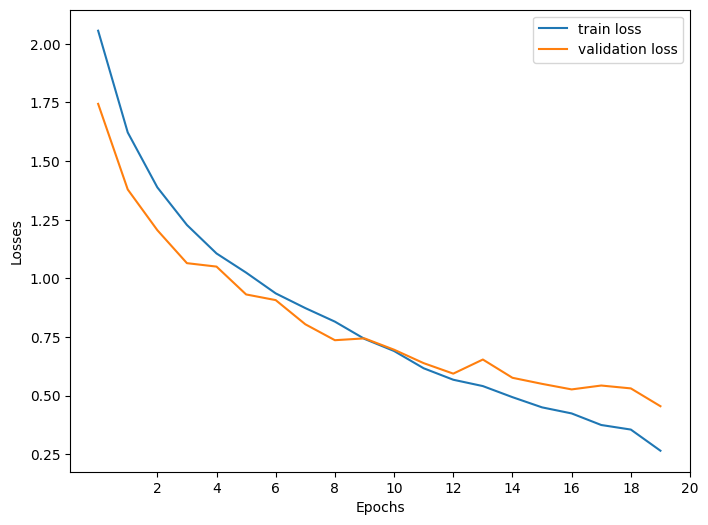

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:10<22:16, 70.36s/it]


epoch:   1, loss: 1.95792, valid loss: 1.63609, valid accruacy: 43.152%
Validation loss decreased (inf --> 1.636088). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:19<20:53, 69.66s/it]


epoch:   2, loss: 1.49652, valid loss: 1.36898, valid accruacy: 52.760%
Validation loss decreased (1.636088 --> 1.368985). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:30<19:53, 70.21s/it]


epoch:   3, loss: 1.25217, valid loss: 1.09674, valid accruacy: 63.037%
Validation loss decreased (1.368985 --> 1.096745). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:44<19:05, 71.57s/it]


epoch:   4, loss: 1.09399, valid loss: 0.97191, valid accruacy: 66.609%
Validation loss decreased (1.096745 --> 0.971907). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:53<17:42, 70.82s/it]


epoch:   5, loss: 0.99391, valid loss: 0.89263, valid accruacy: 69.838%
Validation loss decreased (0.971907 --> 0.892628). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:03<16:24, 70.36s/it]


epoch:   6, loss: 0.87950, valid loss: 0.86532, valid accruacy: 70.984%
Validation loss decreased (0.892628 --> 0.865318). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:14<15:17, 70.61s/it]


epoch:   7, loss: 0.79101, valid loss: 0.74917, valid accruacy: 74.269%
Validation loss decreased (0.865318 --> 0.749167). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:25<14:08, 70.72s/it]


epoch:   8, loss: 0.69639, valid loss: 0.63994, valid accruacy: 79.083%
Validation loss decreased (0.749167 --> 0.639943). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:35<12:55, 70.49s/it]


epoch:   9, loss: 0.61335, valid loss: 0.61502, valid accruacy: 79.694%
Validation loss decreased (0.639943 --> 0.615019). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:44<11:42, 70.21s/it]


epoch:  10, loss: 0.54204, valid loss: 0.55917, valid accruacy: 82.139%
Validation loss decreased (0.615019 --> 0.559173). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [12:57<10:37, 70.87s/it]


epoch:  11, loss: 0.48357, valid loss: 0.48722, valid accruacy: 84.145%
Validation loss decreased (0.559173 --> 0.487216). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:37<10:38, 79.84s/it]


epoch:  12, loss: 0.41702, valid loss: 0.45800, valid accruacy: 86.495%
Validation loss decreased (0.487216 --> 0.457996). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [16:09<09:44, 83.48s/it]


epoch:  13, loss: 0.36975, valid loss: 0.45734, valid accruacy: 86.361%
Validation loss decreased (0.457996 --> 0.457344). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [17:39<08:33, 85.62s/it]


epoch:  14, loss: 0.30645, valid loss: 0.43327, valid accruacy: 87.775%
Validation loss decreased (0.457344 --> 0.433270). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [19:10<07:15, 87.11s/it]


epoch:  15, loss: 0.28771, valid loss: 0.43967, valid accruacy: 88.157%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [20:41<05:53, 88.26s/it]


epoch:  16, loss: 0.25593, valid loss: 0.40432, valid accruacy: 88.997%
Validation loss decreased (0.433270 --> 0.404320). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [22:11<04:26, 88.95s/it]


epoch:  17, loss: 0.24091, valid loss: 0.45549, valid accruacy: 88.405%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [23:42<02:58, 89.50s/it]


epoch:  18, loss: 0.22073, valid loss: 0.41289, valid accruacy: 89.570%
Epoch 00018: reducing learning rate of group 0 to 1.2500e-03.


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [25:13<01:29, 89.97s/it]


epoch:  19, loss: 0.13485, valid loss: 0.39195, valid accruacy: 91.041%
Validation loss decreased (0.404320 --> 0.391949). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [26:44<00:00, 80.21s/it]


epoch:  20, loss: 0.10257, valid loss: 0.37641, valid accruacy: 91.882%
Validation loss decreased (0.391949 --> 0.376407). Saving model...
Fit time: 1604.2448954582214 s


Test loss: 0.45160	Test accruacy: 91.180%
Saving model


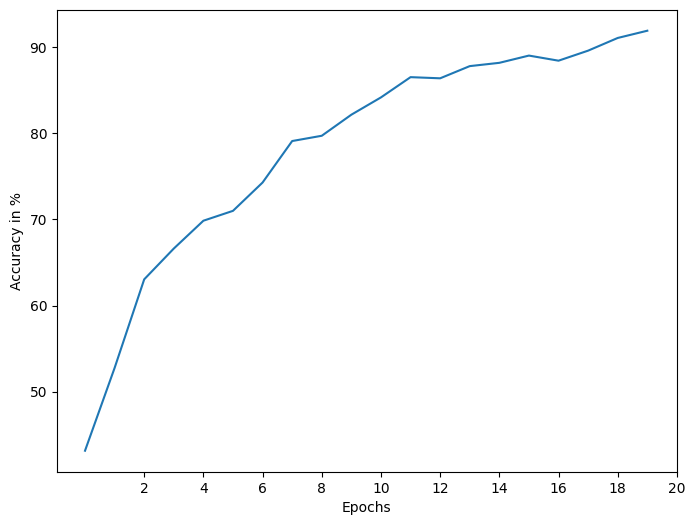

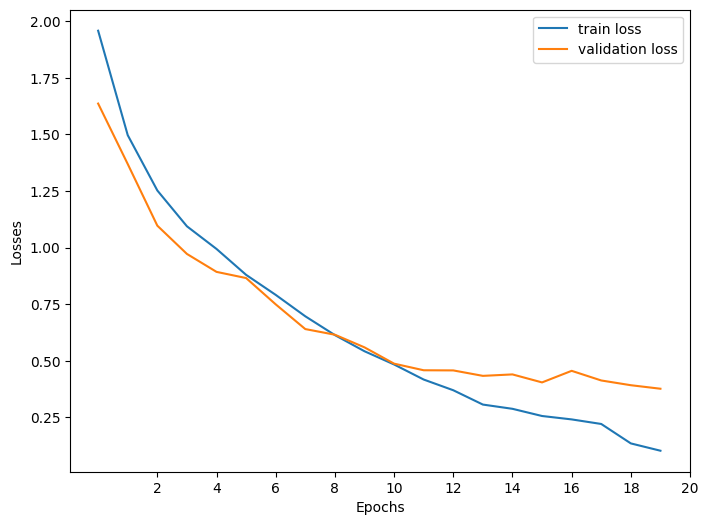

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:33<29:29, 93.11s/it]


epoch:   1, loss: 2.02468, valid loss: 1.69079, valid accruacy: 40.649%
Validation loss decreased (inf --> 1.690789). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [03:06<28:00, 93.38s/it]


epoch:   2, loss: 1.52148, valid loss: 1.29919, valid accruacy: 55.817%
Validation loss decreased (1.690789 --> 1.299189). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [04:41<26:38, 94.02s/it]


epoch:   3, loss: 1.27059, valid loss: 1.10724, valid accruacy: 62.197%
Validation loss decreased (1.299189 --> 1.107235). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [06:15<25:02, 93.90s/it]


epoch:   4, loss: 1.12354, valid loss: 1.02869, valid accruacy: 65.081%
Validation loss decreased (1.107235 --> 1.028688). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [07:25<21:22, 85.53s/it]


epoch:   5, loss: 1.00197, valid loss: 0.96881, valid accruacy: 67.335%
Validation loss decreased (1.028688 --> 0.968807). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [08:36<18:47, 80.54s/it]


epoch:   6, loss: 0.92435, valid loss: 0.86011, valid accruacy: 71.022%
Validation loss decreased (0.968807 --> 0.860113). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [09:46<16:42, 77.11s/it]


epoch:   7, loss: 0.83630, valid loss: 0.79438, valid accruacy: 73.639%
Validation loss decreased (0.860113 --> 0.794379). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [10:56<14:58, 74.88s/it]


epoch:   8, loss: 0.75663, valid loss: 0.70617, valid accruacy: 76.791%
Validation loss decreased (0.794379 --> 0.706170). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [12:09<13:34, 74.06s/it]


epoch:   9, loss: 0.68060, valid loss: 0.68175, valid accruacy: 77.154%
Validation loss decreased (0.706170 --> 0.681750). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [13:20<12:11, 73.12s/it]


epoch:  10, loss: 0.61539, valid loss: 0.64454, valid accruacy: 78.854%
Validation loss decreased (0.681750 --> 0.644539). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [14:30<10:49, 72.20s/it]


epoch:  11, loss: 0.55423, valid loss: 0.61472, valid accruacy: 80.306%
Validation loss decreased (0.644539 --> 0.614716). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [15:40<09:33, 71.70s/it]


epoch:  12, loss: 0.49184, valid loss: 0.56957, valid accruacy: 82.159%
Validation loss decreased (0.614716 --> 0.569566). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [16:51<08:19, 71.31s/it]


epoch:  13, loss: 0.43650, valid loss: 0.51109, valid accruacy: 84.336%
Validation loss decreased (0.569566 --> 0.511089). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [18:01<07:06, 71.01s/it]


epoch:  14, loss: 0.38722, valid loss: 0.50807, valid accruacy: 84.317%
Validation loss decreased (0.511089 --> 0.508071). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [19:11<05:54, 70.82s/it]


epoch:  15, loss: 0.35009, valid loss: 0.47730, valid accruacy: 86.151%
Validation loss decreased (0.508071 --> 0.477296). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [20:22<04:42, 70.63s/it]


epoch:  16, loss: 0.31781, valid loss: 0.48342, valid accruacy: 86.819%


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [21:32<03:32, 70.71s/it]


epoch:  17, loss: 0.27188, valid loss: 0.46777, valid accruacy: 87.698%
Validation loss decreased (0.477296 --> 0.467775). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [22:45<02:22, 71.15s/it]


epoch:  18, loss: 0.28572, valid loss: 0.47891, valid accruacy: 86.915%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [24:00<01:12, 72.30s/it]


epoch:  19, loss: 0.23755, valid loss: 0.44896, valid accruacy: 88.481%
Validation loss decreased (0.467775 --> 0.448955). Saving model...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [25:10<00:00, 75.52s/it]



epoch:  20, loss: 0.21885, valid loss: 0.45448, valid accruacy: 88.634%
Fit time: 1510.388718366623 s
Test loss: 0.41082	Test accruacy: 89.233%
Saving model


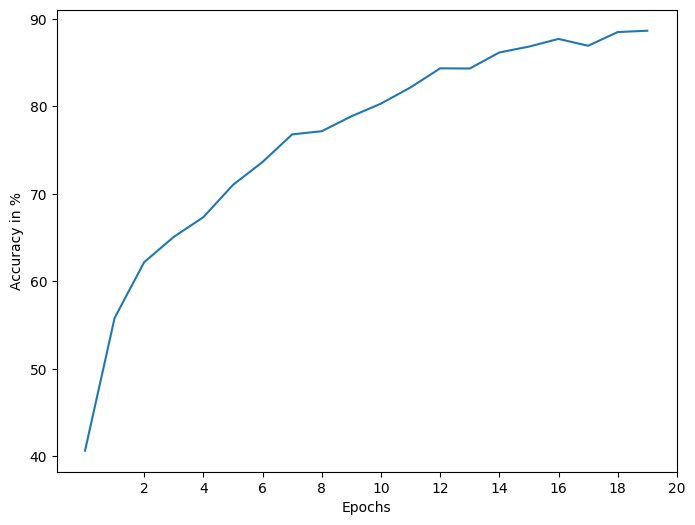

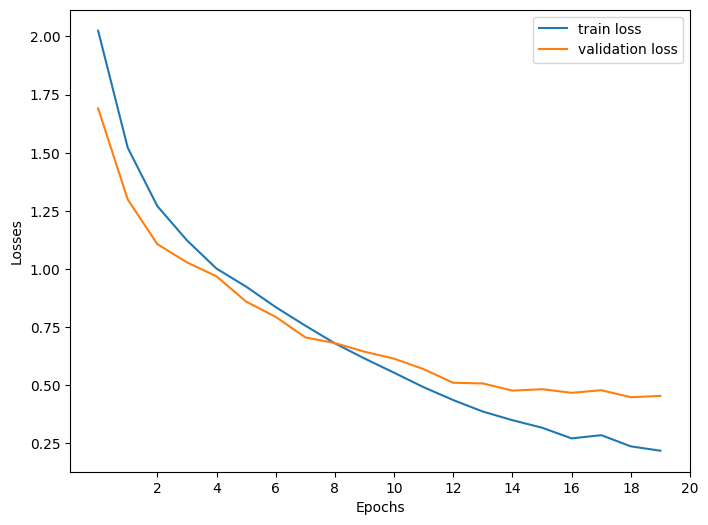

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:10<22:23, 70.71s/it]


epoch:   1, loss: 2.09232, valid loss: 1.79660, valid accruacy: 36.657%
Validation loss decreased (inf --> 1.796601). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:20<21:00, 70.04s/it]


epoch:   2, loss: 1.64737, valid loss: 1.49039, valid accruacy: 49.035%
Validation loss decreased (1.796601 --> 1.490389). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:29<19:47, 69.85s/it]


epoch:   3, loss: 1.43918, valid loss: 1.38180, valid accruacy: 53.295%
Validation loss decreased (1.490389 --> 1.381797). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:41<18:47, 70.48s/it]


epoch:   4, loss: 1.29073, valid loss: 1.19741, valid accruacy: 60.229%
Validation loss decreased (1.381797 --> 1.197413). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:51<17:34, 70.31s/it]


epoch:   5, loss: 1.16200, valid loss: 1.06618, valid accruacy: 64.011%
Validation loss decreased (1.197413 --> 1.066183). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [07:00<16:20, 70.07s/it]


epoch:   6, loss: 1.07786, valid loss: 1.03289, valid accruacy: 65.253%
Validation loss decreased (1.066183 --> 1.032886). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:11<15:11, 70.15s/it]


epoch:   7, loss: 0.98820, valid loss: 0.95047, valid accruacy: 68.023%
Validation loss decreased (1.032886 --> 0.950466). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:21<14:02, 70.21s/it]


epoch:   8, loss: 0.92635, valid loss: 0.86316, valid accruacy: 70.735%
Validation loss decreased (0.950466 --> 0.863159). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:31<12:49, 69.96s/it]


epoch:   9, loss: 0.84441, valid loss: 0.83737, valid accruacy: 71.901%
Validation loss decreased (0.863159 --> 0.837371). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:41<11:41, 70.18s/it]


epoch:  10, loss: 0.78831, valid loss: 0.74983, valid accruacy: 75.244%
Validation loss decreased (0.837371 --> 0.749835). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [12:54<10:38, 70.94s/it]


epoch:  11, loss: 0.71826, valid loss: 0.71839, valid accruacy: 75.836%
Validation loss decreased (0.749835 --> 0.718385). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [14:03<09:24, 70.54s/it]


epoch:  12, loss: 0.64214, valid loss: 0.69421, valid accruacy: 77.784%
Validation loss decreased (0.718385 --> 0.694211). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [15:14<08:14, 70.62s/it]


epoch:  13, loss: 0.58332, valid loss: 0.60376, valid accruacy: 80.649%
Validation loss decreased (0.694211 --> 0.603762). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [16:24<07:02, 70.42s/it]


epoch:  14, loss: 0.52593, valid loss: 0.56238, valid accruacy: 82.101%
Validation loss decreased (0.603762 --> 0.562379). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [17:34<05:51, 70.26s/it]


epoch:  15, loss: 0.45628, valid loss: 0.53223, valid accruacy: 83.859%
Validation loss decreased (0.562379 --> 0.532234). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [18:44<04:40, 70.13s/it]


epoch:  16, loss: 0.41340, valid loss: 0.51822, valid accruacy: 84.852%
Validation loss decreased (0.532234 --> 0.518219). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [19:54<03:30, 70.19s/it]


epoch:  17, loss: 0.36946, valid loss: 0.46126, valid accruacy: 86.590%
Validation loss decreased (0.518219 --> 0.461261). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [21:04<02:19, 69.94s/it]


epoch:  18, loss: 0.32618, valid loss: 0.50598, valid accruacy: 85.138%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [22:14<01:09, 69.96s/it]


epoch:  19, loss: 0.29477, valid loss: 0.46803, valid accruacy: 87.106%
Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:25<00:00, 70.28s/it]


epoch:  20, loss: 0.20343, valid loss: 0.42353, valid accruacy: 88.691%
Validation loss decreased (0.461261 --> 0.423534). Saving model...
Fit time: 1405.5868754386902 s


Test loss: 0.40110	Test accruacy: 89.843%
Saving model


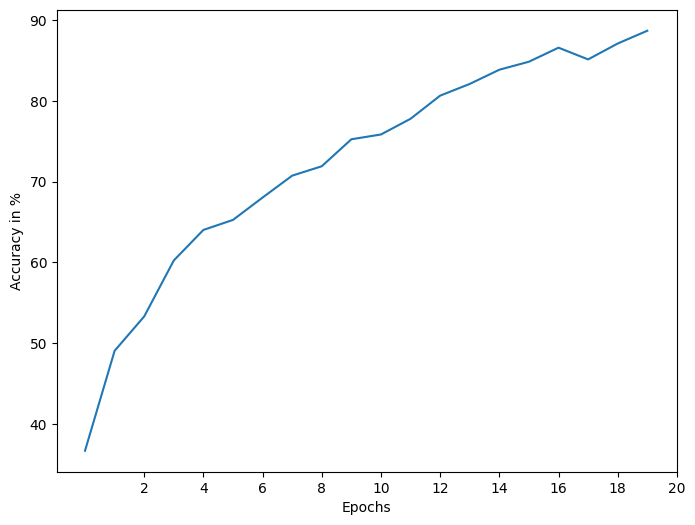

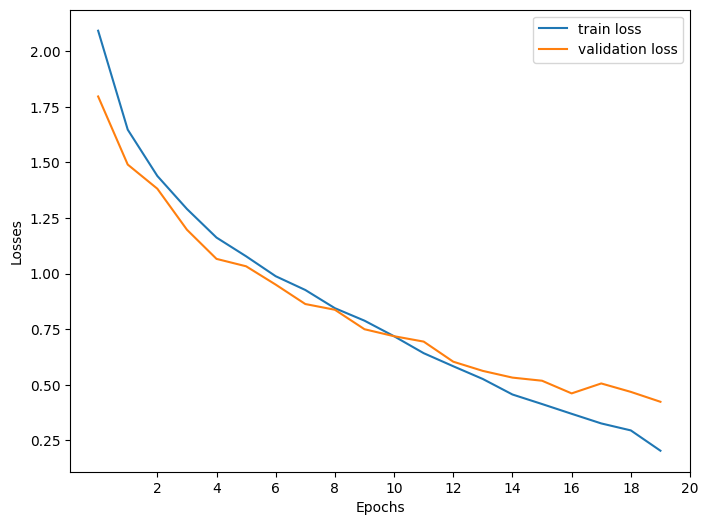

results were saved to csv

Fitting nn model


  5%|█████████▊                                                                                                                                                                                         | 1/20 [01:09<21:52, 69.08s/it]


epoch:   1, loss: 2.06405, valid loss: 1.80138, valid accruacy: 35.454%
Validation loss decreased (inf --> 1.801383). Saving model...


 10%|███████████████████▌                                                                                                                                                                               | 2/20 [02:17<20:39, 68.86s/it]


epoch:   2, loss: 1.70339, valid loss: 1.51293, valid accruacy: 47.030%
Validation loss decreased (1.801383 --> 1.512930). Saving model...


 15%|█████████████████████████████▎                                                                                                                                                                     | 3/20 [03:26<19:29, 68.80s/it]


epoch:   3, loss: 1.47152, valid loss: 1.33736, valid accruacy: 53.696%
Validation loss decreased (1.512930 --> 1.337356). Saving model...


 20%|███████████████████████████████████████                                                                                                                                                            | 4/20 [04:36<18:27, 69.21s/it]


epoch:   4, loss: 1.30401, valid loss: 1.18807, valid accruacy: 59.885%
Validation loss decreased (1.337356 --> 1.188067). Saving model...


 25%|████████████████████████████████████████████████▊                                                                                                                                                  | 5/20 [05:44<17:11, 68.78s/it]


epoch:   5, loss: 1.17752, valid loss: 1.11640, valid accruacy: 61.433%
Validation loss decreased (1.188067 --> 1.116402). Saving model...


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 6/20 [06:52<16:00, 68.64s/it]


epoch:   6, loss: 1.06903, valid loss: 1.00870, valid accruacy: 66.686%
Validation loss decreased (1.116402 --> 1.008702). Saving model...


 35%|████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7/20 [08:01<14:51, 68.58s/it]


epoch:   7, loss: 0.98216, valid loss: 0.90874, valid accruacy: 70.239%
Validation loss decreased (1.008702 --> 0.908744). Saving model...


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8/20 [09:10<13:43, 68.66s/it]


epoch:   8, loss: 0.88737, valid loss: 0.85332, valid accruacy: 71.251%
Validation loss decreased (0.908744 --> 0.853318). Saving model...


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9/20 [10:19<12:37, 68.86s/it]


epoch:   9, loss: 0.81130, valid loss: 0.77305, valid accruacy: 74.288%
Validation loss decreased (0.853318 --> 0.773051). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 10/20 [11:28<11:28, 68.82s/it]


epoch:  10, loss: 0.72748, valid loss: 0.70508, valid accruacy: 76.466%
Validation loss decreased (0.773051 --> 0.705084). Saving model...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 11/20 [12:37<10:21, 69.05s/it]


epoch:  11, loss: 0.64727, valid loss: 0.65191, valid accruacy: 79.045%
Validation loss decreased (0.705084 --> 0.651914). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 12/20 [13:46<09:12, 69.05s/it]


epoch:  12, loss: 0.59409, valid loss: 0.60442, valid accruacy: 81.299%
Validation loss decreased (0.651914 --> 0.604421). Saving model...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 13/20 [14:55<08:02, 68.90s/it]


epoch:  13, loss: 0.50474, valid loss: 0.57268, valid accruacy: 82.464%
Validation loss decreased (0.604421 --> 0.572676). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 14/20 [16:04<06:53, 68.89s/it]


epoch:  14, loss: 0.44575, valid loss: 0.51106, valid accruacy: 84.527%
Validation loss decreased (0.572676 --> 0.511056). Saving model...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 15/20 [17:13<05:44, 69.00s/it]


epoch:  15, loss: 0.39534, valid loss: 0.52474, valid accruacy: 84.527%


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 16/20 [18:22<04:36, 69.02s/it]


epoch:  16, loss: 0.35400, valid loss: 0.49398, valid accruacy: 86.571%
Validation loss decreased (0.511056 --> 0.493984). Saving model...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 17/20 [19:30<03:26, 68.86s/it]


epoch:  17, loss: 0.29499, valid loss: 0.46575, valid accruacy: 86.858%
Validation loss decreased (0.493984 --> 0.465749). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 18/20 [20:38<02:17, 68.61s/it]


epoch:  18, loss: 0.26495, valid loss: 0.47985, valid accruacy: 87.259%


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 19/20 [21:48<01:08, 68.80s/it]


epoch:  19, loss: 0.23299, valid loss: 0.48186, valid accruacy: 87.584%
Epoch 00019: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [22:58<00:00, 68.93s/it]


epoch:  20, loss: 0.16132, valid loss: 0.42509, valid accruacy: 89.666%
Validation loss decreased (0.465749 --> 0.425095). Saving model...
Fit time: 1378.5912754535675 s


Test loss: 0.41290	Test accruacy: 90.645%
Saving model


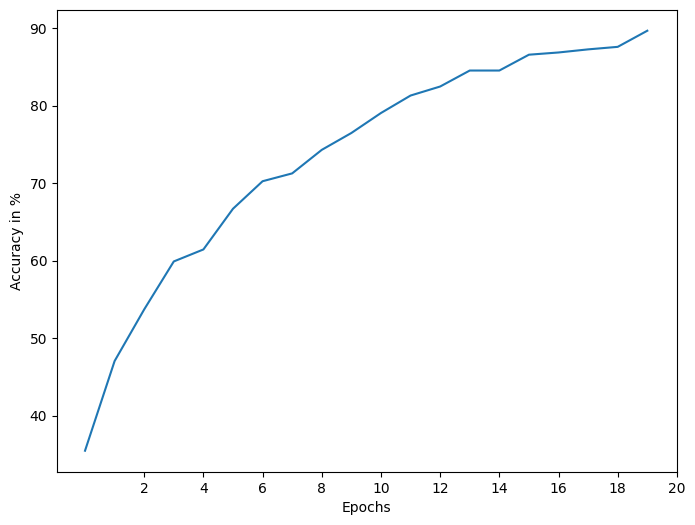

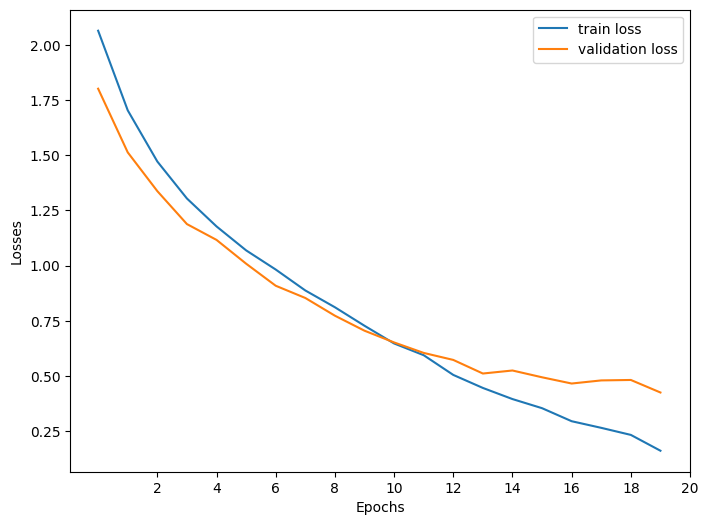

results were saved to csv


In [20]:
df_grid_v1 = grid_search(params_grid)

In [21]:
df_grid_v1

,batch_size,lr,epochs,activation_fn,optimizer,losses_arr,test_loss,test_accuracy,model
0,128,0.0040,20,GELU(approximate='none'),Adam,"[(1.8163915007111158, 1.4374609062300485, 49.8...",0.417577,89.461627,model_0
1,128,0.0040,20,GELU(approximate='none'),AdamW,"[(1.9357123259014843, 1.6394826020074096, 43.1...",0.363195,90.836197,model_1
2,128,0.0025,20,GELU(approximate='none'),Adam,"[(1.8159208363172628, 1.4382288682085054, 49.7...",0.382835,91.065292,model_2
3,128,0.0025,20,GELU(approximate='none'),AdamW,"[(1.7934252289437662, 1.4833902385423836, 48.0...",0.366897,91.714395,model_3
4,128,0.0010,20,GELU(approximate='none'),Adam,"[(1.9272985113984404, 1.6219880747362445, 43.0...",0.418219,90.759832,model_4
5,128,0.0010,20,GELU(approximate='none'),AdamW,"[(1.9025515739198922, 1.6013889266062376, 44.2...",0.392237,90.721649,model_5
6,256,0.0040,20,GELU(approximate='none'),Adam,"[(2.0467352690312905, 1.7559277065390047, 37.6...",0.357297,91.103475,model_6
7,256,0.0040,20,GELU(approximate='none'),AdamW,"[(1.9639601178774242, 1.5746885284197933, 44.4...",0.347108,91.905307,model_7
8,256,0.0025,20,GELU(approximate='none'),Adam,"[(1.9152224069402781, 1.6265795501392004, 43.8...",0.438118,91.447117,model_8
9,256,0.0025,20,GELU(approximate='none'),AdamW,"[(1.8758015180707466, 1.5884689081250312, 45.1...",0.426602,91.179840,model_9


In [38]:
df_res = df_grid_v1.sort_values(by='test_accuracy', ascending=False)
df_res = df_res.reset_index(drop=True)

In [39]:
df_res['train_loss'] = 1
df_res['valid_loss'] = 1
df_res['valid_accuracy'] = 1

In [40]:
# df_res

In [41]:
for i in range(df_res.shape[0]):
    df_res.iloc[i,9] = df_res.iloc[i,5][-1][0]
    df_res.iloc[i,10] = df_res.iloc[i,5][-1][1]
    df_res.iloc[i,11] = df_res.iloc[i,5][-1][2]

In [43]:
df_res.head()

,batch_size,lr,epochs,activation_fn,optimizer,losses_arr,test_loss,test_accuracy,model,train_loss,valid_loss,valid_accuracy
0,256,0.0040,20,GELU(approximate='none'),AdamW,"[(1.9639601178774242, 1.5746885284197933, 44.4...",0.347108,91.905307,model_7,0.111870,0.448500,90.391595
1,128,0.0025,20,GELU(approximate='none'),AdamW,"[(1.7934252289437662, 1.4833902385423836, 48.0...",0.366897,91.714395,model_3,0.081911,0.393717,91.404011
2,256,0.0025,20,GELU(approximate='none'),Adam,"[(1.9152224069402781, 1.6265795501392004, 43.8...",0.438118,91.447117,model_8,0.073264,0.401874,91.098376
3,256,0.0010,20,GELU(approximate='none'),AdamW,"[(1.9701944398684847, 1.6870790057332605, 41.1...",0.448520,91.447117,model_11,0.086805,0.427596,90.620821
4,256,0.0025,20,LeakyReLU(negative_slope=0.01),Adam,"[(1.9579227424806331, 1.6360878131678818, 43.1...",0.451601,91.179840,model_20,0.102569,0.376407,91.881566


In [44]:
df_res.tail()

,batch_size,lr,epochs,activation_fn,optimizer,losses_arr,test_loss,test_accuracy,model,train_loss,valid_loss,valid_accuracy
19,128,0.0025,20,LeakyReLU(negative_slope=0.01),AdamW,"[(1.9918141761548198, 1.845835684750802, 33.86...",0.440706,89.156166,model_15,0.148122,0.414928,90.257880
20,256,0.0040,20,LeakyReLU(negative_slope=0.01),Adam,"[(2.0557376826964164, 1.7955866413562778, 35.0...",0.450546,88.850706,model_18,0.276716,0.422484,88.328558
21,256,0.0040,20,LeakyReLU(negative_slope=0.01),AdamW,"[(2.0557344271541456, 1.7439350192845153, 38.4...",0.471379,87.628866,model_19,0.265345,0.455051,87.717287
22,128,0.0040,20,LeakyReLU(negative_slope=0.01),Adam,"[(2.082473299708243, 1.781233909296329, 36.809...",0.590038,81.748759,model_12,0.568638,0.601631,81.700096
23,128,0.0040,20,LeakyReLU(negative_slope=0.01),AdamW,"[(2.011433310690876, 1.7581004083327372, 37.02...",0.626049,80.030546,model_13,0.511884,0.568411,83.476600


In [45]:
df_res.to_csv('lab5/models/results_v1.csv', sep=',')

## Top 1 model : 91.9% test accuracy; 90.39% valid accuracy

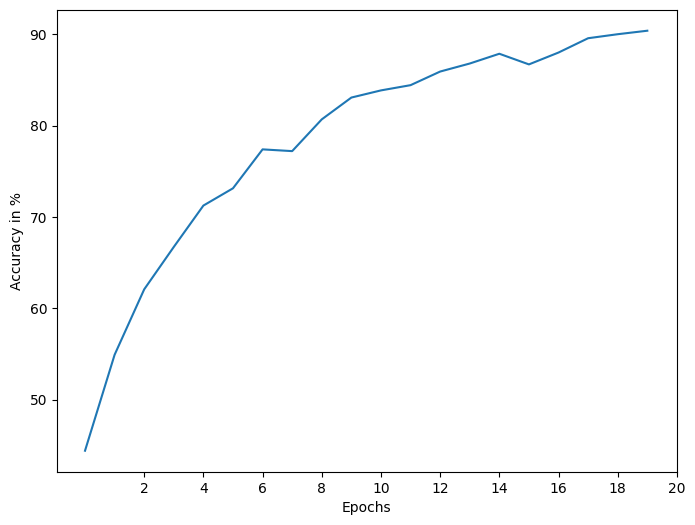

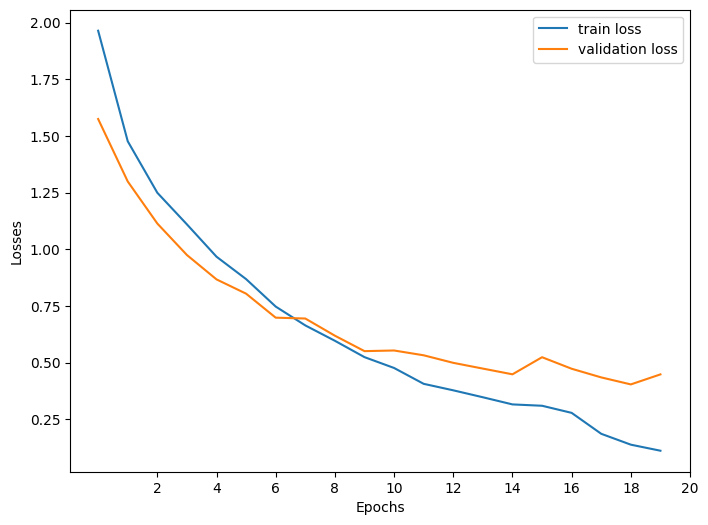

In [26]:
training_plots(df_res.iloc[0,5])

In [63]:
def finalizing_plots(models_losses, model_labels):

    plt.figure(figsize=(10, 6))
    for i, losses_arr in enumerate(models_losses):
        val_acc = [x[2] for x in losses_arr]
        plt.plot(val_acc, label=f'{model_labels[i]}')
    plt.ylabel('Validation Accuracy (%)')
    plt.xlabel('Epochs')
    plt.xticks([x for x in range(len(models_losses[0])) if x % 2 == 1])
    plt.legend(loc='lower right')
    plt.title("Validation Accuracy")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for i, losses_arr in enumerate(models_losses):
        val_loss = [x[1] for x in losses_arr]
        plt.plot(val_loss, label=f'{model_labels[i]}')
    plt.ylabel('Validation Loss')
    plt.xlabel('Epochs')
    plt.xticks([x for x in range(len(models_losses[0])) if x % 2 == 1])
    plt.legend(loc='upper right')
    plt.title("Validation Loss")
    plt.grid(True)
    plt.show()

## Valid loss and Valid accuracy for top 5 models

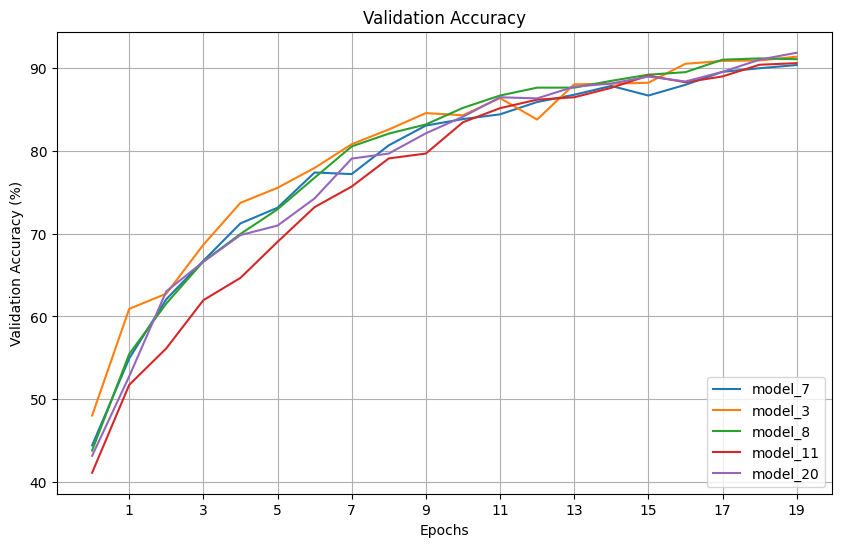

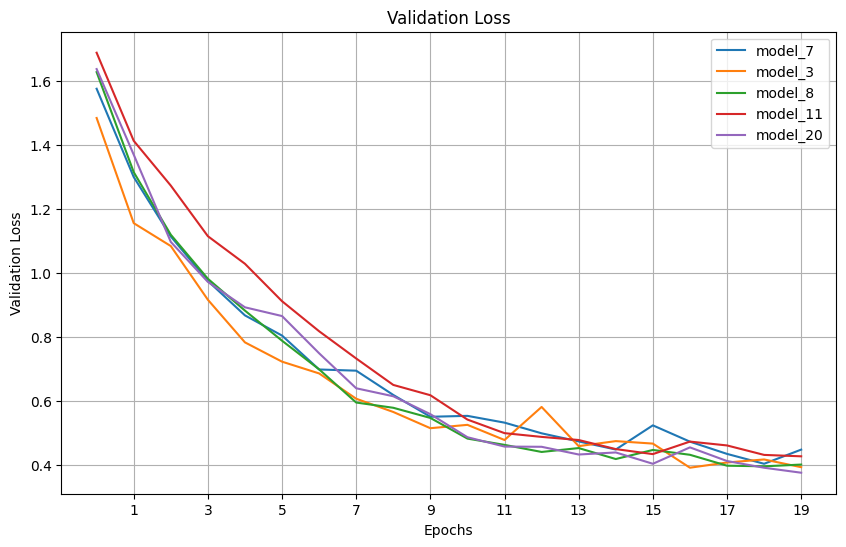

In [64]:
all_models = df_res['losses_arr'].head().values.tolist()
model_labels = df_res['model'].head().values.tolist()

finalizing_plots(all_models, model_labels)

## Valid loss and Valid accuracy for top 5 from the bottom models

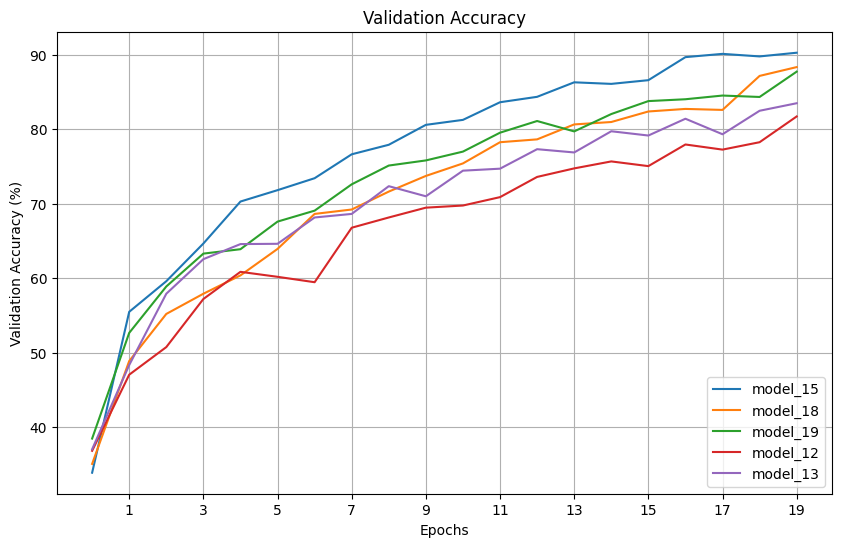

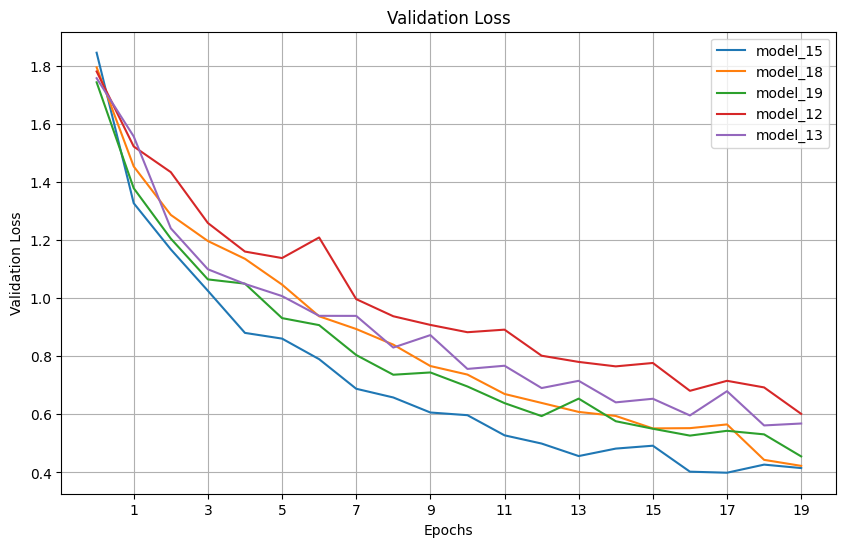

In [65]:
all_models = df_res['losses_arr'].tail().values.tolist()
model_labels = df_res['model'].tail().values.tolist()

finalizing_plots(all_models, model_labels)

## Accuracy vs Hyperparameters

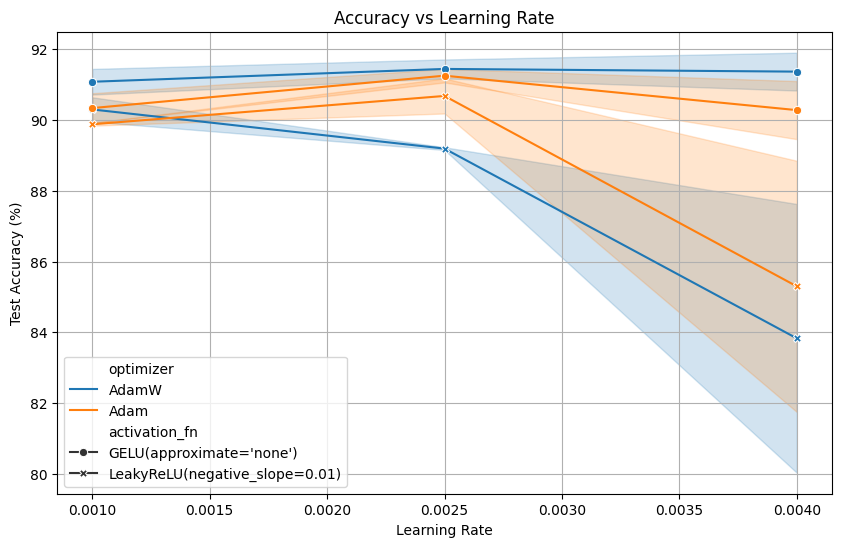

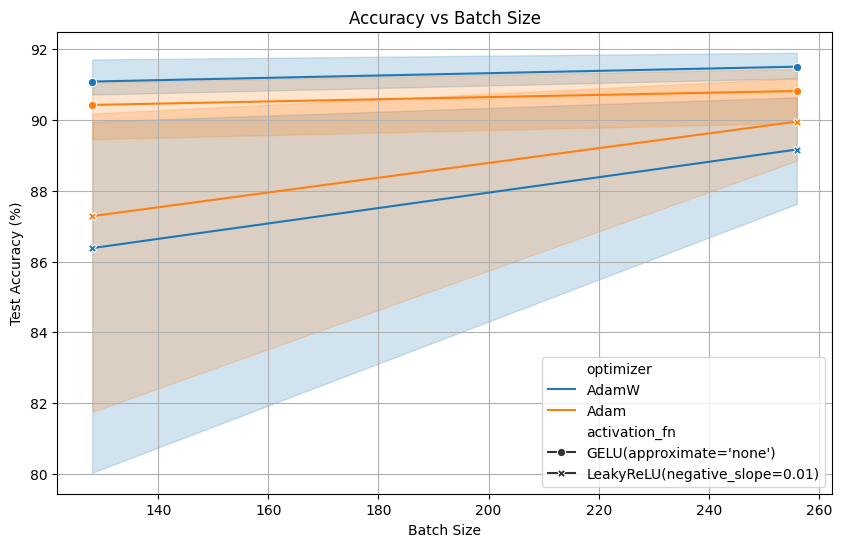

In [70]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_res, x="lr", y="test_accuracy", hue="optimizer", style="activation_fn", markers=True, dashes=False)
plt.title("Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_res, x="batch_size", y="test_accuracy", hue="optimizer", style="activation_fn", markers=True, dashes=False)
plt.title("Accuracy vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

## Conclusions

- successfully performed model and hyperparameter tuning across 24 new models
- validation accuracy surpassed the 90% threshold, reaching a peak of 91.9%
- training curves showed a strong initial learning slope, followed by signs of slight overfitting toward the end
- learning rate scheduler helped, but for 20 epochs we might need to decrease patience to 1 for more impact
- combination of AdamW optimizer and GELU activation function delivered outstanding performance
- batch size variations produced subtle yet decisive differences

## Comparison to earlier trained models in lab4

- Initially, providing more effective model and data augmentation was a key for better performance
- giving more parameters to work with for CNNs managed to extract more valuable features
- as for these training, we selected hyperparameters options that differ from the previous one, we can not surely say what was worse or better. However, we can state that it played a crucial role as well, crossing the 90% threshold 

## Future Work

- increase epochs to reach 95% barrier
- set more options for learning rate
- not sure if other optimizers are handy as in Pytorch docu it states that Adam and AdamW are more stable with cuda
- try out other learning rate schedulers
- somehow to accelerate model training (1 epoch was 1-2 mins -> 20 epochs could take up to 30 mins -> 24 models * 30 mins -> more than 10 hours of training, a bit too much :D)